In [1]:
## SQLite does not handle vector types.

# import sqlite3
# db = sqlite3.connect(:memory:) 
# dolly_data.to_sql(name='dolly_data', con=db)
# db = sqlite3.connect('dolly_data.sql')
# dolly_data = pd.read_sql("select * from dolly_data", db)
# Q = "select instruction, response, instruction_A, instruction_B, resp_A, resp_B from dolly_data limit 10"
# pd.read_sql(Q, db)

In [2]:
### Copied to "Aspect aware semantic clustering" notebook

%matplotlib inline

import matplotlib.pyplot as plt

import pickle
import pandas as pd
import numpy as np
import os.path

from corpus_characterization_utils import *

from utils import utils
from ThoughtGrapher import ThoughtGrapher

tgraph = ThoughtGrapher()

SENTENCE_TRANSFORMER_MODEL_NAME = 'all-MiniLM-L6-v2'

DATA_FILE = f'dolly_data_{SENTENCE_TRANSFORMER_MODEL_NAME}.parquet' # 'dolly_data_all-mpnet-base-v2.parquet'
dolly_data = pd.read_parquet(DATA_FILE).rename(columns={
    'inst_A':'instruction_A', 'inst_B':'instruction_B',
    'resp_A':'response_A', 'resp_B': 'response_B',
})
dolly_data

,instruction,context,response,category,has_context,instruction_vector,response_vector,instruction_A,instruction_B,response_A,response_B
15002,Which is a species of fish? Banjo or Guitar,,Banjo,classification,False,"[-0.031613580882549286, 0.02204715646803379, -...","[-0.058731645345687866, 0.02958996407687664, -...",inst_A08,inst_B51,resp_A01,resp_B001
19,Identify which instrument is string or percuss...,,"Gudok is string, Cantaro is percussion.",classification,False,"[-0.023818423971533775, 0.04866934195160866, -...","[-0.047977667301893234, 0.007309707347303629, ...",inst_A09,inst_B53,resp_A01,resp_B001
27,Identify which instrument is string or woodwin...,,"Zurna is woodwind, Panduri is string.",classification,False,"[-0.007988017983734608, 0.05960787460207939, -...","[0.005874082446098328, 0.03250544145703316, -0...",inst_A09,inst_B53,resp_A01,resp_B001
62,Identify which instrument is string or percuss...,,"Shamisen is string, Kpanlogo is percussion.",classification,False,"[0.04195571690797806, 0.03711291775107384, -0....","[0.05845625326037407, 0.008080583065748215, -0...",inst_A09,inst_B53,resp_A01,resp_B001
90,Identify which instrument is string or percuss...,,"Viola toeria is string, Samphor is percussion.",classification,False,"[0.031926609575748444, -0.01929675228893757, -...","[0.04793274775147438, -0.04417796805500984, -0...",inst_A09,inst_B53,resp_A01,resp_B001
...,...,...,...,...,...,...,...,...,...,...,...
8421,What are some interesting facts about Nelson M...,Nelson Mandela Boulevard (Persian: بلوار نلسون...,It holds a mixture of residential and commerci...,summarization,True,"[0.039251651614904404, 0.09270037710666656, -0...","[0.09583701938390732, 0.03630739822983742, -0....",inst_A15,inst_B85,resp_A15,resp_B101
10200,What is the best way to get from London to Paris.,,To travel from London to Paris you have severa...,general_qa,False,"[0.10140563547611237, -0.03675508126616478, 0....","[0.04922645539045334, -0.06915348023176193, 0....",inst_A15,inst_B85,resp_A15,resp_B101
14919,Given a reference text that describes the air ...,In response to concerns that volcanic ash ejec...,Initially there was an uninterrupted shutdown ...,closed_qa,True,"[0.023408792912960052, 0.04394981265068054, 0....","[0.07181950658559799, -0.014206488616764545, 0...",inst_A15,inst_B86,resp_A15,resp_B101
6012,What is a good slogan for carpet?,,Here are some good slogans for carpet:\n\n- Th...,brainstorming,False,"[0.003218281315639615, 0.034283023327589035, 0...","[0.0023823166266083717, -0.02614438533782959, ...",inst_A15,inst_B89,resp_A15,resp_B101


In [3]:
len(dolly_data['instruction_vector'][0])

384

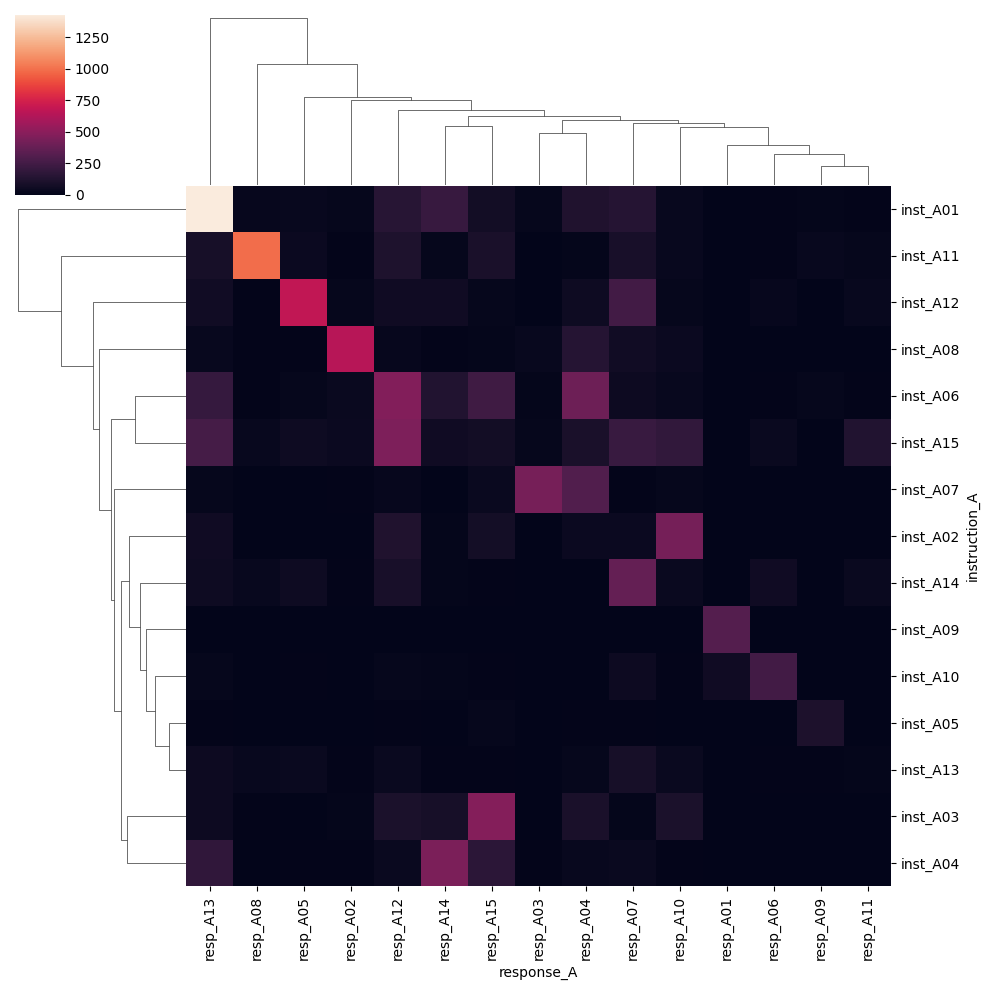

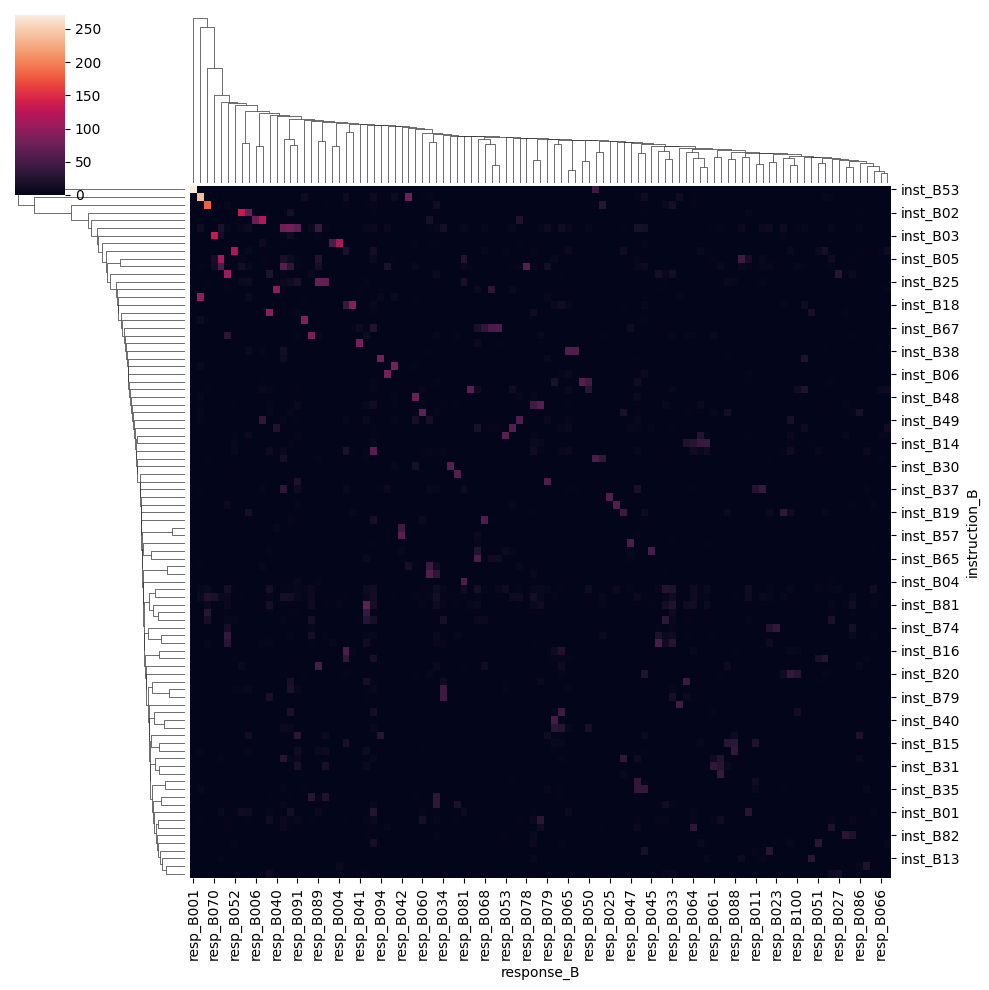

In [4]:
import seaborn as sns

for letter in 'AB':
    X = pd.crosstab(dolly_data[f'instruction_{letter}'], dolly_data[f'response_{letter}'])
    sns.clustermap(X)

# Co-occurrence

In [5]:
dd_wide = dolly_data[ ['category', 'instruction_B', 'response_B'] ] \
    .reset_index() \
    .rename(columns={'index':'basket', 'instruction_B': 'instruction_cluster', 'response_B': 'response_cluster'})

basket_item = pd.melt(dd_wide, 
                        id_vars='basket', 
                        value_vars=['category', 'instruction_cluster', 'response_cluster'],
                        var_name='type', value_name='thing'
                     ).sort_values(['basket', 'type'])

basket_item['item'] = basket_item['type'] + '::' + basket_item['thing']

basket_item = basket_item[ ['basket', 'item']]

basket_item

,basket,item
9744,0,category::closed_qa
24755,0,instruction_cluster::inst_B01
39766,0,response_cluster::resp_B069
4501,1,category::classification
19512,1,instruction_cluster::inst_B51
...,...,...
26375,15009,instruction_cluster::inst_B09
41386,15009,response_cluster::resp_B076
6334,15010,category::general_qa
21345,15010,instruction_cluster::inst_B57


In [6]:
item_pair_stats = utils.get_item_pair_stats(basket_item)

item_pair_stats.sort_values('confidence', ascending=False)[0:15]

,item1,item2,item1_count,item2_count,both_count,item1_prevalence,item2_prevalence,confidence,lift
4650,response_cluster::resp_B001,category::classification,274,2136,272,0.018253,0.142296,0.992701,6.976325
4653,response_cluster::resp_B001,instruction_cluster::inst_B53,274,317,271,0.018253,0.021118,0.989051,46.834845
4747,response_cluster::resp_B006,instruction_cluster::inst_B52,75,246,74,0.004996,0.016388,0.986667,60.206721
4745,response_cluster::resp_B006,category::classification,75,2136,74,0.004996,0.142296,0.986667,6.933920
3825,instruction_cluster::inst_B73,response_cluster::resp_B025,58,68,57,0.003864,0.004530,0.982759,216.943966
6066,response_cluster::resp_B049,category::classification,64,2136,62,0.004264,0.142296,0.968750,6.808009
6070,response_cluster::resp_B049,instruction_cluster::inst_B28,64,176,61,0.004264,0.011725,0.953125,81.291815
3248,instruction_cluster::inst_B53,category::classification,317,2136,296,0.021118,0.142296,0.933754,6.562069
3798,instruction_cluster::inst_B72,category::open_qa,99,3742,92,0.006595,0.249284,0.929293,3.727850
3793,instruction_cluster::inst_B71,response_cluster::resp_B022,65,112,60,0.004330,0.007461,0.923077,123.717033


In [7]:
nodes, edges = utils.get_nodes_and_edges_from_item_pair_stats( item_pair_stats[ item_pair_stats['both_count'] > 15 ] )

nodes = nodes.rename(columns={'label':'type_label'})
nodes

Your graph will have 199 nodes and 1694 edges.


,type_label,count,prevalence,id
0,category::brainstorming,1766,0.117647,0
1,category::classification,2136,0.142296,1
2,category::closed_qa,1773,0.118113,2
3,category::creative_writing,709,0.047232,3
4,category::general_qa,2191,0.145960,4
...,...,...,...,...
194,response_cluster::resp_B097,66,0.004397,194
195,response_cluster::resp_B098,91,0.006062,195
196,response_cluster::resp_B099,162,0.010792,196
197,response_cluster::resp_B100,83,0.005529,197


In [8]:
type_color = {'category': '#FF9999', 'instruction_cluster': '#99FFFF', 'response_cluster': '#FFFF99'}

# use different shapes for categories that use context and those that do not
category_shape = {'brainstorming': 'box', 'classification': 'box', 'creative_writing': 'box', 
                  'general_qa': 'box', 'open_qa': 'box',
                  'closed_qa': 'star', 'information_extraction': 'star', 'summarization': 'star',
                  'instruction_cluster': 'ellipse', 'response_cluster': 'ellipse'}

nodes['type'] = [ x.split('::')[0] for x in nodes['type_label'] ]
nodes['label'] = [ x.split('::')[1] for x in nodes['type_label'] ]     # text displayed on the node
nodes['color'] = [ type_color[my_type] for my_type in nodes['type'] ]

   
nodes['shape'] = [ category_shape[row['label']] if row['type'] == 'category' else 'ellipse' for row in nodes.to_dict(orient='records') ]



nodes['title'] = [ utils.make_cluster_node_title(row, dolly_data) for row in nodes.to_dict(orient='records') ]


nodes

,type_label,count,prevalence,id,type,label,color,shape,title
0,category::brainstorming,1766,0.117647,0,category,brainstorming,#FF9999,box,"brainstorming\n(category, 1766 examples)"
1,category::classification,2136,0.142296,1,category,classification,#FF9999,box,"classification\n(category, 2136 examples)"
2,category::closed_qa,1773,0.118113,2,category,closed_qa,#FF9999,star,"closed_qa\n(category, 1773 examples)"
3,category::creative_writing,709,0.047232,3,category,creative_writing,#FF9999,box,"creative_writing\n(category, 709 examples)"
4,category::general_qa,2191,0.145960,4,category,general_qa,#FF9999,box,"general_qa\n(category, 2191 examples)"
...,...,...,...,...,...,...,...,...,...
194,response_cluster::resp_B097,66,0.004397,194,response_cluster,resp_B097,#FFFF99,ellipse,"resp_B097\n(response_cluster, 66 examples)\nIc..."
195,response_cluster::resp_B098,91,0.006062,195,response_cluster,resp_B098,#FFFF99,ellipse,"resp_B098\n(response_cluster, 91 examples)\nEa..."
196,response_cluster::resp_B099,162,0.010792,196,response_cluster,resp_B099,#FFFF99,ellipse,"resp_B099\n(response_cluster, 162 examples)\nT..."
197,response_cluster::resp_B100,83,0.005529,197,response_cluster,resp_B100,#FFFF99,ellipse,"resp_B100\n(response_cluster, 83 examples)\nA ..."


In [9]:
edges['weight'] = edges['confidence']

edges[edges['weight'] > 0.25]

,from,to,both_count,confidence,lift,weight
1444,8,2,47,0.259669,2.198468,0.259669
1446,8,5,46,0.254144,2.533168,0.254144
1501,9,6,162,0.632812,2.538522,0.632812
1517,9,170,134,0.523438,38.706011,0.523438
1518,9,171,72,0.281250,20.594360,0.281250
...,...,...,...,...,...,...
7805,195,26,33,0.362637,32.020879,0.362637
7824,196,4,57,0.351852,2.410611,0.351852
7846,196,47,49,0.302469,78.282141,0.302469
7864,197,27,29,0.349398,33.406415,0.349398


In [10]:
# from utils import utils
# my_utils = utils()
# my_utils.export_to_vis_js(nodes, edges[edges['confidence'] > 0.25], 
    # title="Cluster co-occurrence", html_file_name=f'cluster_cooccurrence_{SENTENCE_TRANSFORMER_MODEL_NAME}.html')

In [11]:

SENTENCE_TRANSFORMER_MODEL_NAME
# vis_js_html = get_vis_js_html(nodes, edges[edges['confidence'] > 0.25])
# from IPython.display import HTML
# HTML(vis_js_html)

'all-MiniLM-L6-v2'

# Predicting Patterns

In [103]:
pat = r'of the following'  # 'book' but not 'book a flight'


# to do: exclude 'computer science', 'political science', 'data science', 'science fiction'
# This doesn't work: 
# None: 'tabular'
# r'\b(reference|following) text' # 'story about' write a|(story about|diary entry)

# 'Write a short story about a woman named '
# r'\b(both sides|pro and con|pros and cons|for and against)' # 'argument'
# Please fix the typos and grammar issues in the following text

import regex  # allows alternatives in negative lookarounds
flagged = [ x for x in dolly_data['instruction']  if regex.search(pat, x, regex.IGNORECASE) ]
len(flagged)

467

In [20]:
### Copied to "Aspect aware semantic clustering" notebook

import regex # allows alternatives in negative lookarounds
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

MODELS_FILE = f'models_LogisticRegressionCV_{SENTENCE_TRANSFORMER_MODEL_NAME}.pkl'
# MODELS_FILE = 'models_LogisticRegressionCV_l2_no_intercept.pkl'

# Prefixing patterns by r'\b' ensures they must be at the beginning of a word. 
# This way 'eat' does not match 'great', and most plurals will be OK.
patterns = { 
    # domains
    'cars': r"\b(automobile|car|Toyota|Ford|Dodge|Jeep|Fiat)",
    'animals': r"\b(animal|cat|dog|pet)",
    'food': r"\b(food|diet|eat|restaurant)",
    'programming_language': r"\bprogramming language",
    'sports': r'\baseball(?!: bat)|basketball|badminton|tennis(?!: shoe)|soccer|futbol|football (?!: stadium)',
    'science': r"(?<![:?])(?<!(computer|political|data)) science (?!fiction)|biology|(?<!blood )chemistry|physics|astromony",
    'science_fiction': r"science fiction",
    'data_science': r"data science|machine learning|statistic|quantitative|probability|artificial intelligence|AI\b",
    'information_technology': r"technology|software|information|open source|spark",
    'books': r"\b(book(?!: a )|books|novel|literature|literary)\b",  # 'book' but not 'book a flight'

    # instructions
    'identify': r'identify|classify|which',
    'how_does': r'how (do|does)\b',
    'why_is': r'why (is|are)',
    'what is': r'what (is|are)',
    'extract': r'extract ([^:.?]+) from',
    'of_the_following': r'of the following',
    
    # instruction structure
    'given_text': r"\b(given a|given the|the given|based on|reference text|as a reference|the following text)",  # passage|paragraph
    'alternatives': r',|\b(or)\b',

    # output format
    'output_format': r"(display|the results|as a (bulleted )?list|list them|format this|format them|in the format|each record|new line|comma separated|separated by|separate them with a comma|JSON|XML|markdown)", 
}


if os.path.exists(MODELS_FILE):
    models = pickle.load( open(MODELS_FILE, 'rb') )

else:
    models = {}
    
    for text_col in ['instruction', 'response']:
        vector_col = text_col + "_vector"
        l1_ratios = [0.01, 0.1, 0.5]
        X = [v for v in dolly_data[vector_col]]
        for topic in patterns.keys():
            pattern = patterns[topic]
            flags = [bool(regex.search(pattern, sent, regex.IGNORECASE)) for sent in dolly_data[text_col]]
            # clf = LogisticRegression(C=1, max_iter=10000)
            clf = LogisticRegressionCV(cv=5, scoring='roc_auc', # fit_intercept=False, 
                                       n_jobs=-1, max_iter=10000)
            # clf = LogisticRegressionCV(cv=5, penalty='elasticnet', solver='saga', l1_ratios=l1_ratios, scoring='roc_auc', max_iter=10000)
            clf.fit(X, flags)
            flag_col = text_col + '_' + topic
            score_col = flag_col + '_score'
            models[flag_col] = {'model': clf, 'flags': flags, 'scores': clf.predict_proba(X)[:,1]}
            # dolly_data[flag_col] = flags
            # dolly_data[score_col] = clf.predict_proba(X)[:,1]
    
    pickle.dump(models, open(MODELS_FILE, 'wb'))


for flag_col in models.keys():
    model_info = models[flag_col]
    dolly_data[flag_col] = model_info['flags']
    score_col = flag_col + '_score'
    dolly_data[score_col] = model_info['scores']

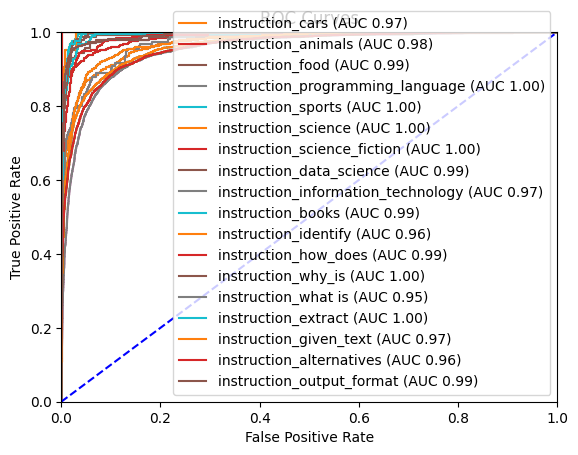

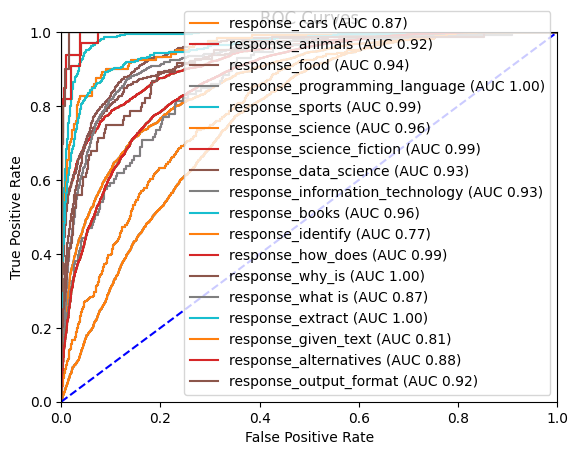

In [21]:
### Copied to "Aspect_aware_semantic_clustering" notebook

list( models.keys() )

from sklearn import metrics

def plot_multiple_ROC_curves(score_flag_dict):
    plt.title('ROC Curves')
    for target in score_flag_dict.keys():
        model_info = score_flag_dict[target]
        fpr, tpr, threshold = metrics.roc_curve(model_info['flags'], model_info['scores'])
        roc_auc = metrics.auc(fpr, tpr)
        plt.plot(fpr, tpr)
        plt.plot(fpr, tpr, #'b', 
                 label = f'{target} (AUC {roc_auc:0.2f})')

    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'b--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

plot_multiple_ROC_curves({k:dict for k,dict in models.items() if k.startswith('instruction')})

plot_multiple_ROC_curves({k:dict for k,dict in models.items() if k.startswith('response')})

In [22]:
def swap_parts(col_name):
    parts = col_name.split('_')
    return parts[1] + '_' + parts[0]

score_cols = [col_name for col_name in dolly_data.columns if '_score' in col_name]
score_cols.sort(key=swap_parts)

M_corr = dolly_data[score_cols].corr()
M_corr

,instruction_alternatives_score,response_alternatives_score,instruction_animals_score,response_animals_score,instruction_books_score,response_books_score,instruction_cars_score,response_cars_score,instruction_data_science_score,response_data_science_score,...,instruction_science_score,instruction_science_fiction_score,response_science_score,response_science_fiction_score,instruction_sports_score,response_sports_score,instruction_what is_score,response_what is_score,instruction_why_is_score,response_why_is_score
instruction_alternatives_score,1.000000,-0.059712,0.211012,0.008774,0.002758,-0.053040,0.184187,-0.062075,0.060080,-0.037976,...,0.099140,0.017620,-0.091351,-0.090363,-0.010759,-0.040531,-0.335351,-0.283125,-0.122414,-0.233840
response_alternatives_score,-0.059712,1.000000,0.024196,0.144137,-0.020483,0.064998,-0.001131,0.233456,0.019134,0.073486,...,-0.020558,-0.007213,0.096306,0.052638,-0.003188,0.054436,0.140543,0.418863,0.072373,0.263994
instruction_animals_score,0.211012,0.024196,1.000000,0.608783,-0.016465,-0.029424,0.051089,0.013155,-0.022265,-0.044573,...,-0.045193,-0.006119,-0.062213,-0.041420,-0.035158,-0.043931,-0.083303,-0.036008,-0.005782,-0.032820
response_animals_score,0.008774,0.144137,0.608783,1.000000,0.012468,0.042359,0.012630,0.161888,-0.018065,-0.011931,...,-0.026787,-0.003775,0.036256,0.040952,-0.033730,-0.027729,0.025315,0.144042,0.011845,0.101180
instruction_books_score,0.002758,-0.020483,-0.016465,0.012468,1.000000,0.678430,-0.031391,-0.037402,-0.007392,-0.015448,...,0.149433,0.362366,0.078245,0.412718,-0.035755,-0.043194,-0.024618,0.048932,-0.030735,0.023821
response_books_score,-0.053040,0.064998,-0.029424,0.042359,0.678430,1.000000,-0.038772,0.027486,-0.010139,-0.001869,...,0.134358,0.240735,0.156853,0.520765,-0.050427,-0.061084,0.007356,0.204301,-0.024390,0.133186
instruction_cars_score,0.184187,-0.001131,0.051089,0.012630,-0.031391,-0.038772,1.000000,0.456701,0.006765,-0.017436,...,-0.024756,-0.012264,-0.042004,-0.086970,0.009663,-0.010722,-0.098106,-0.051700,-0.026830,-0.040672
response_cars_score,-0.062075,0.233456,0.013155,0.161888,-0.037402,0.027486,0.456701,1.000000,-0.024892,-0.003090,...,-0.029493,-0.021778,0.032640,-0.050508,-0.001137,-0.002496,0.002719,0.313086,0.027933,0.224400
instruction_data_science_score,0.060080,0.019134,-0.022265,-0.018065,-0.007392,-0.010139,0.006765,-0.024892,1.000000,0.568941,...,0.107595,0.003614,0.074809,0.034653,-0.013877,-0.018727,-0.014715,0.016932,-0.021926,0.018999
response_data_science_score,-0.037976,0.073486,-0.044573,-0.011931,-0.015448,-0.001869,-0.017436,-0.003090,0.568941,1.000000,...,0.158783,0.004751,0.206910,0.087461,-0.028536,-0.035899,0.046243,0.084242,-0.010577,0.082891


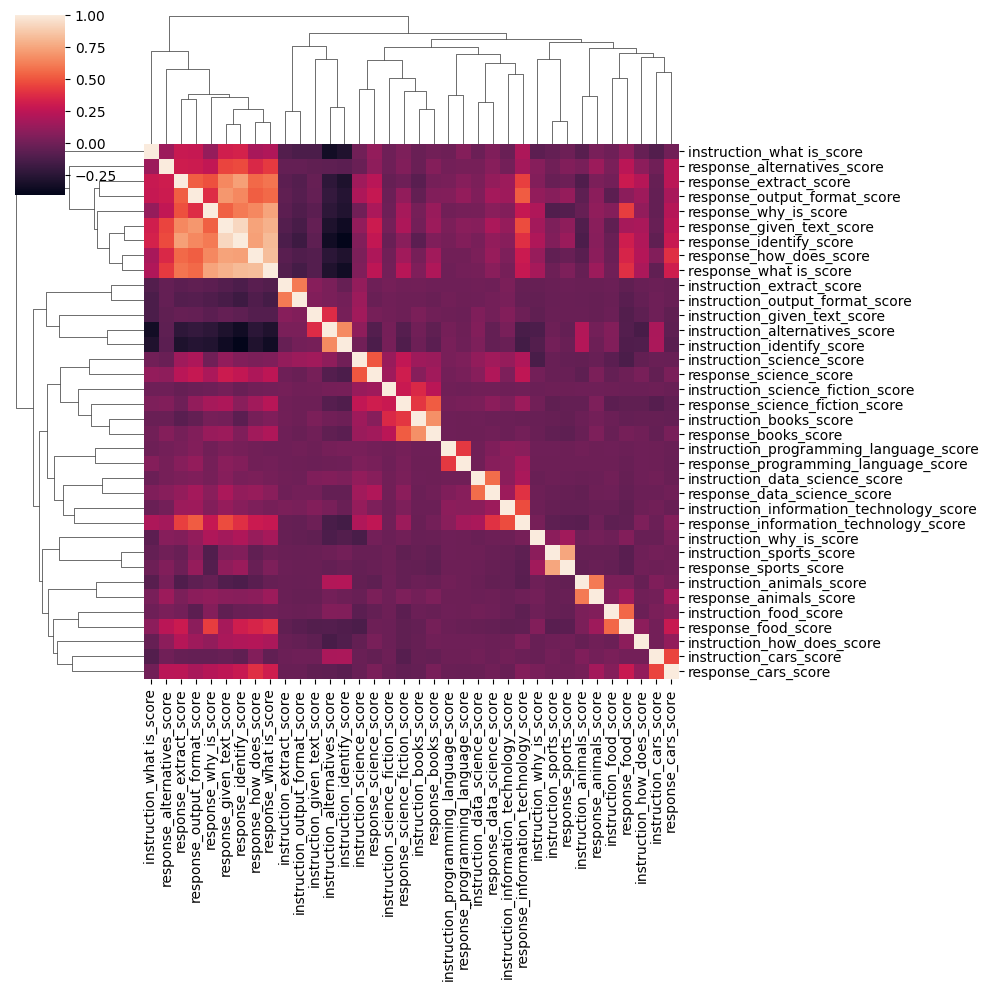

In [23]:
sns.clustermap(M_corr)

In [24]:
### Copied to "Aspect aware semantic clustering" notebook

# pd.DataFrame([{'topic': topic, 'coef': models[topic].coef_[0]} for topic in models.keys()])
M_coef = pd.DataFrame([models[topic]['model'].coef_[0] for topic in models.keys()] , index=[k for k in models.keys()]).transpose()
print("number of coefficients:", len(M_coef))  # one row per embedding dimension

M_coef

number of coefficients: 384


,instruction_cars,instruction_animals,instruction_food,instruction_programming_language,instruction_sports,instruction_science,instruction_science_fiction,instruction_data_science,instruction_information_technology,instruction_books,...,response_information_technology,response_books,response_identify,response_how_does,response_why_is,response_what is,response_extract,response_given_text,response_alternatives,response_output_format
0,0.312190,3.054559,0.578443,-1.036920,-1.591741,-0.002279,-0.247748,-0.707692,-0.242628,-0.197968,...,-1.077735,-0.149853,0.000384,0.000085,0.000014,0.012581,-0.000016,-0.003967,-0.200709,-0.137007
1,1.759256,-1.618592,-1.009891,-4.293039,-1.997003,-0.000619,-0.256163,-4.032402,1.644040,-0.445442,...,-0.477947,-0.547774,-0.000208,-0.000096,0.000015,0.011466,0.000013,-0.010442,-8.947999,0.315136
2,1.743429,1.021845,1.312946,0.220640,0.155901,0.000734,1.247220,1.011646,0.719790,-0.296614,...,-0.164699,-0.313290,0.000449,0.000091,0.000045,0.025485,-0.000009,-0.011186,-0.864316,0.030047
3,3.310545,1.248537,1.835569,-1.195510,-1.333135,0.001404,0.355072,2.768037,-0.750012,0.552403,...,-0.784550,0.725049,0.000076,0.000005,0.000022,-0.001806,0.000020,-0.020568,-5.793453,-0.310953
4,-1.630853,-1.112826,-0.985020,-0.848624,0.074404,0.001493,0.514947,3.315426,1.189763,-1.082020,...,0.859901,-1.486640,0.001599,0.000132,0.000040,0.015074,0.000031,0.009211,-3.167102,-0.058950
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
379,0.587614,-0.035196,-1.469360,-0.142963,-0.942240,-0.002018,-0.855709,-1.161826,0.032089,-0.322296,...,0.810362,-0.094009,0.000447,0.000084,0.000017,0.041638,0.000011,-0.004523,3.543097,0.180157
380,-5.777462,1.597588,-0.283913,-3.052075,0.329016,0.006392,-0.060236,1.790153,-0.515185,0.368998,...,-0.234647,0.155204,-0.001648,-0.000083,0.000013,0.018248,-0.000013,-0.014373,-1.980187,0.044844
381,0.667365,1.069154,1.258120,0.304799,-1.328681,-0.000043,-0.408419,-0.244865,-0.965316,-0.761740,...,-0.598620,-0.600644,0.000536,0.000297,0.000003,0.099751,0.000010,0.013859,-2.948067,0.218197
382,0.572917,0.673723,-1.314996,0.665792,-0.711498,0.000268,-0.766936,-2.461842,-0.689822,-0.862837,...,-0.173059,-1.030474,-0.000799,-0.000259,-0.000052,-0.065064,0.000014,-0.008791,-7.260619,-0.358366


<Axes: ylabel='Density'>

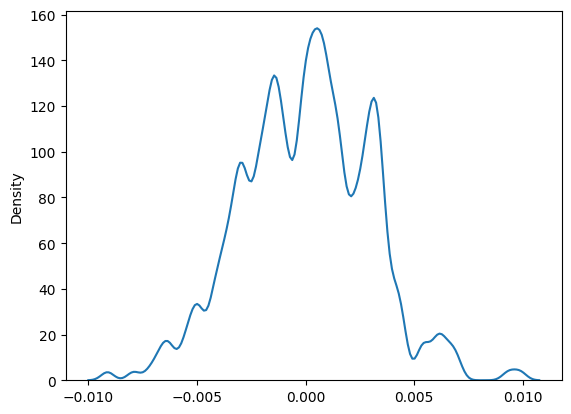

In [25]:
topic = 'instruction_science' # 'instruction_animals' # 'instruction_alternatives'

sns.kdeplot(np.array(M_coef[topic]), bw_method=0.1)

In [26]:
topic = 'instruction_alternatives'
model = models[topic]['model']

dir( model )

# model.fit_intercept
model.intercept_[0]


M_coef[topic]

np.sum(M_coef['instruction_alternatives'])

-738.0973471518262

In [27]:
### Copied to "Aspect aware semantic clustering" notebook

def get_model_stats(my_models):
    all_models_stats = []
    for topic in my_models:
        my_stats = {}
        model = my_models[topic]['model']
        cv_scores = [ max(vc) for vc in model.scores_[True] ]  # (n_folds, n_cs)
        my_stats['topic'] = topic
        my_stats['number_of_cases'] = np.sum(my_models[topic]['flags'])
        my_stats['intercept'] = model.intercept_[0]
        my_stats['cv_auc_mean'] = np.mean(cv_scores)
        my_stats['coef_std'] = np.std(model.coef_[0])
        my_stats['coef_min'] = np.min(model.coef_[0])
        my_stats['coef_mean'] = np.mean(model.coef_[0])
        my_stats['coef_max'] = np.max(model.coef_[0])
        all_models_stats.append(my_stats)
        
    return pd.DataFrame(all_models_stats)


model_stats = get_model_stats(models)
model_stats

,topic,number_of_cases,intercept,cv_auc_mean,coef_std,coef_min,coef_mean,coef_max
0,instruction_cars,536,-5.514938,0.901369,2.870177,-7.915646,-3.483665e-01,9.054671
1,instruction_animals,694,-4.444007,0.959107,1.505176,-3.728922,-6.013031e-02,4.686525
2,instruction_food,233,-6.481981,0.980549,1.177250,-3.876871,3.700957e-03,4.252732
3,instruction_programming_language,24,-16.873609,0.999933,2.216473,-5.975073,3.331303e-02,7.623810
4,instruction_sports,343,-6.617523,0.986970,1.268126,-3.896551,-4.271812e-02,3.833336
5,instruction_science,21,-6.571004,0.981805,0.002937,-0.009120,9.732552e-06,0.009874
6,instruction_science_fiction,17,-8.047238,0.989774,0.607449,-1.823362,4.008987e-04,1.415780
7,instruction_data_science,141,-7.590975,0.901828,2.574285,-7.324217,-1.670508e-01,7.932527
8,instruction_information_technology,155,-5.403396,0.882749,1.113617,-3.395230,-2.122882e-02,3.174848
9,instruction_books,218,-5.098919,0.991034,0.568549,-1.801276,4.142023e-03,1.742671


<Axes: xlabel='intercept', ylabel='number_of_cases'>

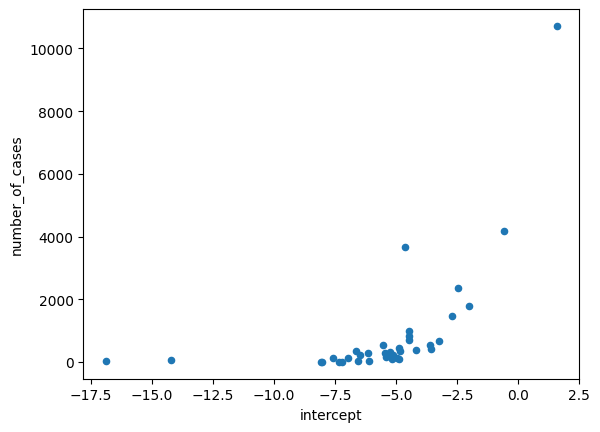

In [28]:
model_stats.plot.scatter(x='intercept', y='number_of_cases')  # inverse_num_cases, number_of_cases, log10_num_cases

<Axes: xlabel='cv_auc_mean', ylabel='coef_std'>

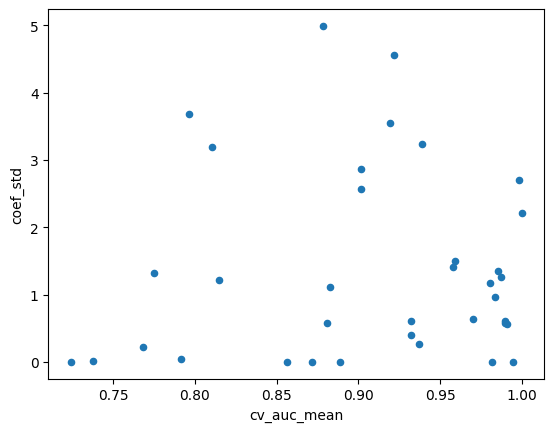

In [29]:
model_stats.plot.scatter(x='cv_auc_mean', y='coef_std')

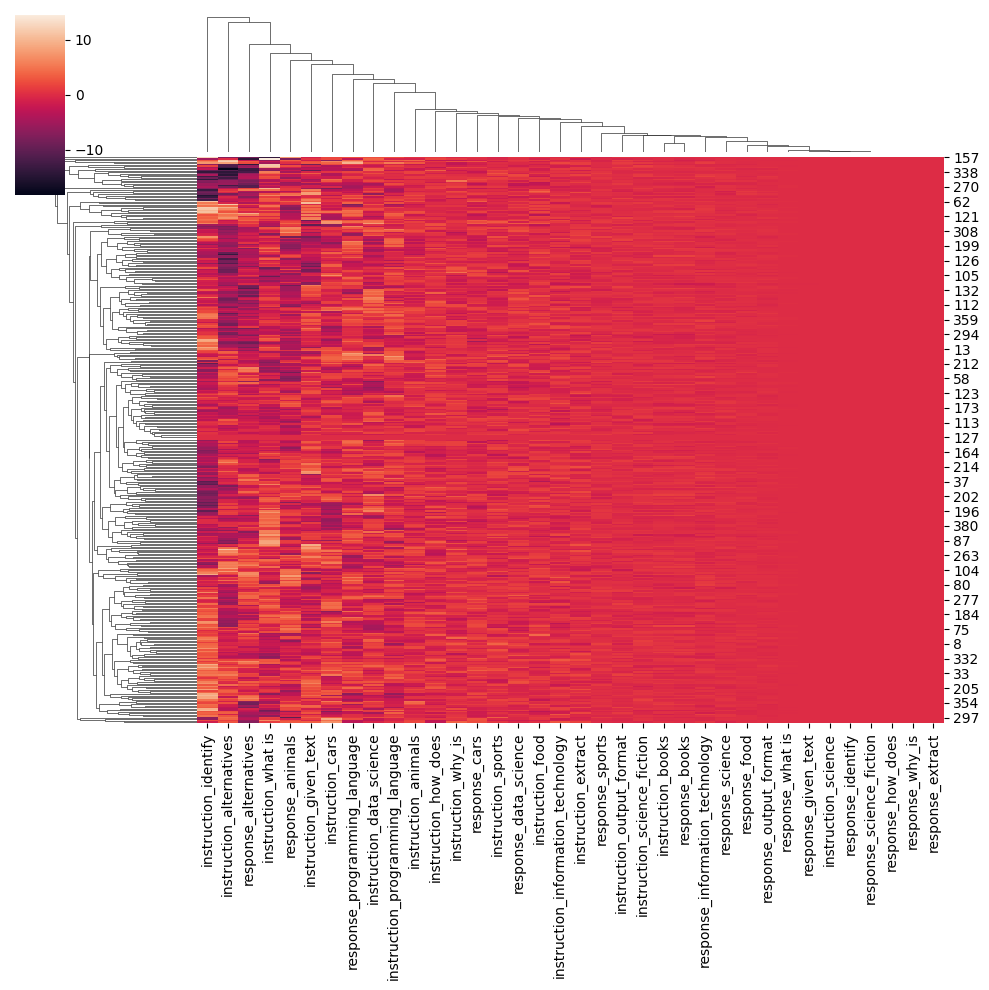

In [30]:
# plt.matshow(M_coef) # does not display

sns.clustermap(M_coef)

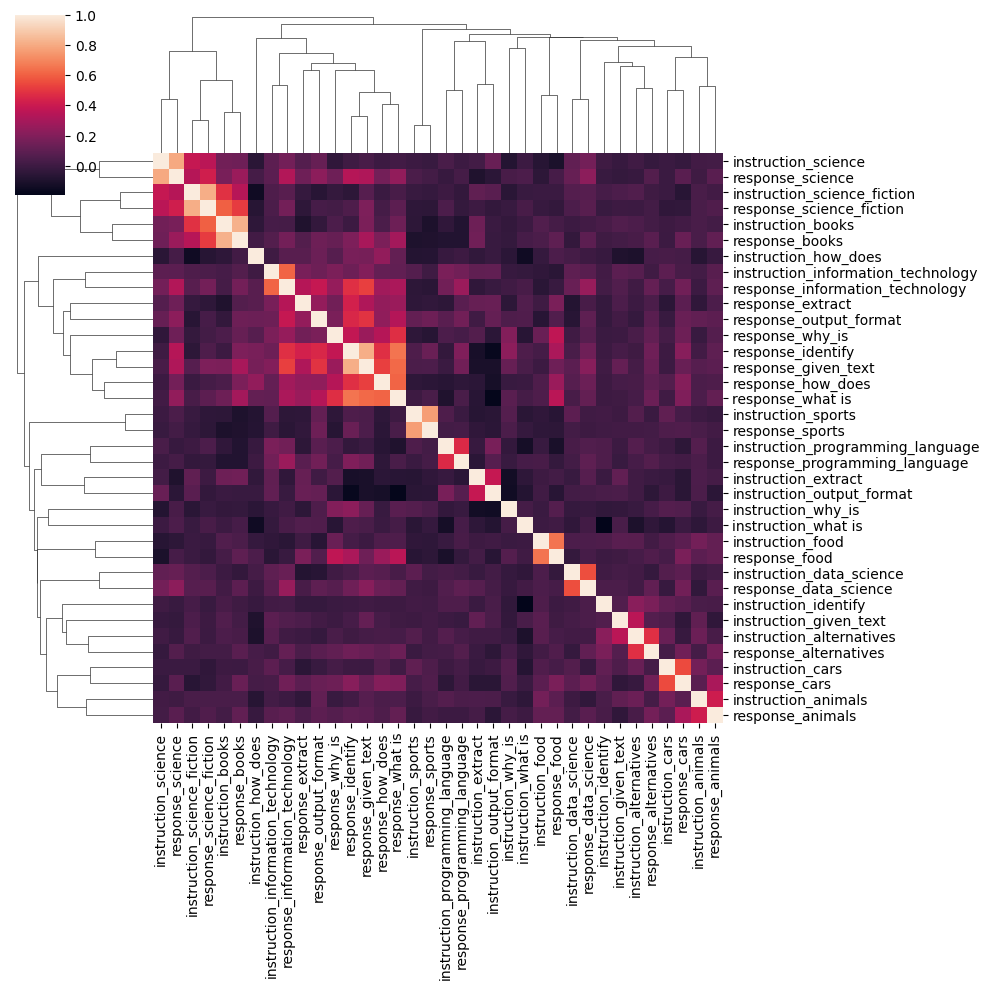

In [31]:
sns.clustermap(M_coef.corr())

In [32]:
# pd.crosstab(dolly_data['instruction_animals'], dolly_data['response_animals'])

for topic in patterns.keys():
    xtab = pd.crosstab(dolly_data[f'instruction_{topic}'], dolly_data[f'response_{topic}'])
    display(xtab)

response_cars,False,True
instruction_cars,,
False,13352,1123
True,182,354


response_animals,False,True
instruction_animals,,
False,13706,611
True,316,378


response_food,False,True
instruction_food,,
False,14262,516
True,69,164


response_programming_language,False,True
instruction_programming_language,,
False,14949,38
True,10,14


response_sports,False,True
instruction_sports,,
False,14476,192
True,101,242


response_science,False,True
instruction_science,,
False,14883,107
True,7,14


response_science_fiction,False,True
instruction_science_fiction,,
False,14974,20
True,4,13


response_data_science,False,True
instruction_data_science,,
False,14617,253
True,33,108


response_information_technology,False,True
instruction_information_technology,,
False,14396,460
True,64,91


response_books,False,True
instruction_books,,
False,14524,269
True,93,125


response_identify,False,True
instruction_identify,,
False,10982,1678
True,2254,97


response_how_does,False,True
instruction_how_does,,
False,14705,10
True,295,1


response_why_is,False,True
instruction_why_is,,
False,14716,9
True,285,1


response_what is,False,True
instruction_what is,,
False,11279,76
True,3619,37


response_extract,False,True
instruction_extract,,
False,14885,5
True,121,0


response_given_text,False,True
instruction_given_text,,
False,13822,361
True,785,43


response_alternatives,False,True
instruction_alternatives,,
False,3026,7805
True,1268,2912


response_output_format,False,True
instruction_output_format,,
False,14612,76
True,315,8


In [33]:
from IPython.display import display, HTML

def get_top_negatives(flag_col):
    text_col = flag_col.split('_')[0]
    return dolly_data[ dolly_data[flag_col] == False ] \
        .sort_values(flag_col + '_score', ascending=False) \
        .head(30)[[text_col, flag_col, flag_col + '_score', 'instruction_A']]

def tabulate_flag_matches(flag_col, threshold=0.5):
    flag_match = [score > threshold for score in dolly_data[flag_col + '_score']]
    # pd.crosstab(dolly_data['instruction_A'], dolly_data[flag_col])
    
    xtab = pd.crosstab(dolly_data['instruction_A'], flag_match)
    xtab['fraction_true'] = [ row[True]/(row[False] + row[True]) for row in xtab.to_dict(orient="records")]
    return xtab.sort_values('fraction_true', ascending=False)

# classify
# extract [... and separate them with a comma]
# write; write a short paragraph about
# instruction format: comma-separated lists, newline-separated lists
# requested format: a short bulleted list

# Jokes dolly_data.loc[8226]

In [34]:
HTML(get_top_negatives('instruction_animals').to_html())

,instruction,instruction_animals,instruction_animals_score,instruction_A
9562,"Identify from this list what creatures are felines: panther, jaguar, elephant, kitten, human child, leopard, tiger, malamute, sofa",False,0.989092,inst_A08
11425,"Classify the following as living things and non-living things: Car, Desk, Parrot, Cheetah, Phone",False,0.883488,inst_A08
2424,"Classify each of the following as either a Carnivore or a Herbivore: Cow, Shark, Zebra, Lion, Wolf, Elephant, Tiger, Deer, Leopard, Cheetah",False,0.858573,inst_A08
13780,"Which of these Disney cartoons were remade as a live action movie? Lion King, Toy Story, Aladdin, Jungle Book, Fox and the Hound, Shrek",False,0.814326,inst_A12
8272,"Classify each of these as extinct, not extinct, or neither: Mythosaur, Triceratops, Dumbo Octopus, Dodo, Tiger, Lion turtle, Megalodon, Dire wolf, Pegasus, Seahorse",False,0.771078,inst_A08
1475,What kind of Toys should be prepare for a new puppy,False,0.732126,inst_A08
10238,"Classify each as either an amphibian, bird, or fish: salmon, trout, salamander, cardinal, owl, falcon, frog",False,0.730600,inst_A08
5357,Classify each of the following as either a true statement or a false statement: \n1. Albert Einstein was a Chinese mathematician that lived in the 19th and 20th century.\n2. Pigs are not mammals.\n3. This question contains four statements that need classification.,False,0.725470,inst_A01
8313,"Please tell me whether these are fish or fowl: salmon, chicken, tuna, swordfish, turkey, and halibut.",False,0.704998,inst_A08
2394,provide the list of the List of American foods that is related to breeds,False,0.700127,inst_A08


In [35]:
display(tabulate_flag_matches('instruction_animals'))

col_0,False,True,fraction_true
instruction_A,,,
inst_A08,601,420,0.411361
inst_A12,1254,28,0.021841
inst_A06,1586,34,0.020988
inst_A04,923,12,0.012834
inst_A05,174,2,0.011364
inst_A07,859,9,0.010369
inst_A01,2265,18,0.007884
inst_A14,762,4,0.005222
inst_A03,959,5,0.005187


In [36]:
display(tabulate_flag_matches('response_animals'))

col_0,False,True,fraction_true
instruction_A,,,
inst_A08,746,275,0.269344
inst_A12,1240,42,0.032761
inst_A07,844,24,0.027650
inst_A04,910,25,0.026738
inst_A06,1581,39,0.024074
inst_A01,2236,47,0.020587
inst_A13,356,7,0.019284
inst_A14,754,12,0.015666
inst_A15,1626,21,0.012750


In [37]:
# Cluster inst_A20 is largely about cats and dogs

a20 = dolly_data[dolly_data['instruction_A'] == 'inst_A20'][['instruction', 'instruction_animals', 'instruction_animals_score', 'instruction_A']]
HTML(a20.to_html())

,instruction,instruction_animals,instruction_animals_score,instruction_A


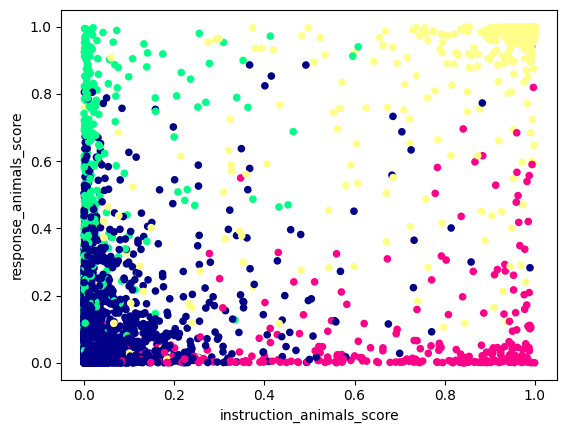

In [38]:
def flags_to_color(flag1, flag2):
    r = 'FF' if flag1 else '00'
    g = 'FF' if flag2 else '00'
    b = '88'
    return f"#{r}{g}{b}"

point_color = [ flags_to_color(row['instruction_animals'], row['response_animals']) for row in dolly_data.to_dict(orient='records') ] 
point_color
ax = dolly_data.plot.scatter('instruction_animals_score', 'response_animals_score', c=point_color)
# legend outside of plot 
# ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))


In [39]:
HTML(get_top_negatives('instruction_food').to_html())

,instruction,instruction_food,instruction_food_score,instruction_A
10233,"Classify these as protein, fats or carbohydrate sources: steak, yogurt, cheese, bananas, bread, pasta",False,0.916761,inst_A07
3719,"Of the items, tomato, broccoli, plane, sausage, pineapple, grass, honey, and milk would a human not like to consume?",False,0.883797,inst_A07
4621,"Classify each of the following as either a vegetarian option or not: chicken fried rice, green beans, strawberry banana smoothie, oatmeal, steak, scrambled eggs",False,0.851620,inst_A07
9983,What are some healthy lunch ideas?,False,0.801552,inst_A07
9828,What are the most common meals?,False,0.791919,inst_A07
13755,What is considered a good meal?,False,0.776632,inst_A07
8631,What does a typical meal look like,False,0.734286,inst_A07
11724,"Which of these could we use to feed our kid: apple, sandwich, beer, xanax, carrot, rock.",False,0.692495,inst_A07
12120,"Select the dishes that are Chinese from this menu: hamburger, pizza, fried rice, soup dumplings, spaghetti, scallion pancakes.",False,0.682373,inst_A07
11496,"Classify each of the following as edible or not edible: hamburger, toast, rubber, leather, pizza, plastic",False,0.649272,inst_A07


In [40]:
tabulate_flag_matches('instruction_food', threshold=0.5)

col_0,False,True,fraction_true
instruction_A,,,
inst_A07,725,143,0.164747
inst_A08,1006,15,0.014691
inst_A04,926,9,0.009626
inst_A02,779,2,0.002561
inst_A12,1280,2,0.001560
inst_A15,1645,2,0.001214
inst_A03,963,1,0.001037
inst_A06,1619,1,0.000617
inst_A01,2283,0,0.000000


In [41]:
# a15 is mostly about food
a15 = dolly_data[dolly_data['instruction_A'] == 'inst_A15'][['instruction', 'instruction_food', 'instruction_food_score']]
HTML(a15.to_html())

,instruction,instruction_food,instruction_food_score
10398,What is the difference between a sitar and a tanpura?,False,0.000980
9917,What makes a Squishmallow resellable?,False,0.000573
9452,"Based on this paragraph, what is the diameter of a 10 F Foley catheter in mm?",False,0.000050
12986,"Given a reference text about the adverse affects of Foley catheters, please list the main risks.",False,0.000939
9461,"What are some of the ways that people celebrate the ""Jindo's Sea Way"" festival in South Korea?",False,0.004711
6523,"Which is bigger, a beagle or a basset?",False,0.002995
11102,How did the American Foxhound originate?,False,0.000853
10811,What is the national bird of India,False,0.004967
941,"Given a reference text about the Mauritius fody, tell me what they look like.",False,0.000763
6792,"Given this paragraph about the Ain Elzarga Wetland, why is this location one of the most important wetlands in the region?",False,0.002537


In [42]:
# Identify which [car manufacturer] is [Japanese or American]: [Honda, Buick]	  A_08

## Beyond the scop of pre-2021 training data?:
# Which of these movies were nominated for Best Picture? "All Quiet on the Western Front", "Everything Everywhere All at Once", "Avatar: The Way of Water", "Glass Onion", "Pinocchio", "Navalny", "The Whale".


## Anthropomorphism
# Who is the biggest inspiration in your life?

In [43]:
HTML(get_top_negatives('instruction_cars').to_html())

,instruction,instruction_cars,instruction_cars_score,instruction_A
7976,"Classify the vehicles based on the number of wheels use to ply on.\nAutorickshaw, SUV, Sedan, Motorcycles",False,0.886847,inst_A06
10007,Tell me whether these are electric or gas powered vehicles,False,0.880838,inst_A01
12498,What are some movies starring Chevy Chase,False,0.855027,inst_A12
11638,Please write a summary of the kinds of vehicles that are used for ambulances.,False,0.854364,inst_A06
11058,"Classify each of the following as supercar or hypercar: Lamborghini Huracán, Ferrari 488GTB, Aston Martin Vantage, or Bugatti Veryron.",False,0.843869,inst_A05
8690,"Classify each of the following teams as college or professional: Florida Gators, Miami Marlins, Miami Hurricanes, Jacksonville Jaguars, Georgia Bulldogs, Atlanta Braves, Tampa Rays",False,0.820665,inst_A11
2974,Give me a list of the most popular vehicle brands in the United States.,False,0.819131,inst_A05
14419,"Classify each of these as ground transportation or aviation transportation: airplane, truck, bicycle, unicycle, jet, wagon, helicopter.",False,0.803318,inst_A06
11174,"What category do these items belong to:\n- Apple\n- Pear\n- Banana\n- Orange\n- Pineapple\n- Guava\n\nThe possible categories are: Fruits, Vegetables, Minerals.",False,0.783316,inst_A07
11496,"Classify each of the following as edible or not edible: hamburger, toast, rubber, leather, pizza, plastic",False,0.748829,inst_A07


In [44]:
tabulate_flag_matches('instruction_cars', threshold=0.5)

col_0,False,True,fraction_true
instruction_A,,,
inst_A05,44,132,0.750000
inst_A06,1559,61,0.037654
inst_A04,909,26,0.027807
inst_A07,851,17,0.019585
inst_A01,2248,35,0.015331
inst_A08,1009,12,0.011753
inst_A13,359,4,0.011019
inst_A03,954,10,0.010373
inst_A11,1532,15,0.009696


# N-gram features

In [45]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer( ngram_range=(5,9), min_df=5, stop_words=None)  # min_df==5: 2871, 10:1137
instruction_ngram_counts_matrix = count_vect.fit_transform(dolly_data['instruction'])
instruction_ngram_counts_matrix.shape

(15011, 1008)

In [46]:
instruction_ngram_counts_pdf = pd.DataFrame(data = instruction_ngram_counts_matrix.todense(), columns = count_vect.get_feature_names_out())
# HTML( instruction_ngram_counts_pdf[1:100].to_html() )

instruction_ngram_counts_pdf.columns

Index(['60 year old personal training', '60 year old personal training client',
       '60 year old personal training client wants',
       '60 year old personal training client wants to',
       '60 year old personal training client wants to improve',
       'about large language models what', 'about the history of the',
       'according to this paragraph about', 'according to this paragraph what',
       'all of the dates mentioned',
       ...
       'year old personal training client wants to',
       'year old personal training client wants to improve',
       'year old personal training client wants to improve her',
       'you are the last person', 'you are the last person on',
       'you are the last person on earth',
       'you are the last person on earth write',
       'you are the last person on earth write diary',
       'you going for walk today', 'you tell me about the'],
      dtype='object', length=1008)

In [47]:
instruction_ngram_counts_pdf.sum(axis=0)

60 year old personal training                            5
60 year old personal training client                     5
60 year old personal training client wants               5
60 year old personal training client wants to            5
60 year old personal training client wants to improve    5
                                                        ..
you are the last person on earth                         5
you are the last person on earth write                   5
you are the last person on earth write diary             5
you going for walk today                                 6
you tell me about the                                    5
Length: 1008, dtype: int64

In [48]:
instruction_ngram_counts_pdf.head()

,60 year old personal training,60 year old personal training client,60 year old personal training client wants,60 year old personal training client wants to,60 year old personal training client wants to improve,about large language models what,about the history of the,according to this paragraph about,according to this paragraph what,all of the dates mentioned,...,year old personal training client wants to,year old personal training client wants to improve,year old personal training client wants to improve her,you are the last person,you are the last person on,you are the last person on earth,you are the last person on earth write,you are the last person on earth write diary,you going for walk today,you tell me about the
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [49]:
basket_item = utils.pivot_term_document_matrix_to_basket_item(instruction_ngram_counts_pdf)

In [50]:
basket_item

,basket,item
0,0,which is species of fish
1,1,identify which instrument is string
2,1,identify which instrument is string or
3,1,identify which instrument is string or percussion
4,1,instrument is string or percussion
...,...,...
16385,15007,is the best way to get
16386,15007,the best way to get
16387,15007,what is the best way
16388,15007,what is the best way to


In [51]:
item_pair_stats = utils.get_item_pair_stats(basket_item)

item_pair_stats.sort_values('confidence', ascending=False)[0:15]

,item1,item2,item1_count,item2_count,both_count,item1_prevalence,item2_prevalence,confidence,lift
0,60 year old personal training,60 year old personal training client,5,5,5,0.001481,0.001481,1.0,675.400000
13619,paragraph and list them using bullets,paragraph and list them using bullets in,26,26,26,0.007699,0.007699,1.0,129.884615
13643,paragraph and list them using bullets,this paragraph and list them using,26,26,26,0.007699,0.007699,1.0,129.884615
13642,paragraph and list them using bullets,this paragraph and list them,26,28,26,0.007699,0.008291,1.0,120.607143
13638,paragraph and list them using bullets,them using bullets in the format,26,37,26,0.007699,0.010956,1.0,91.270270
13637,paragraph and list them using bullets,them using bullets in the,26,37,26,0.007699,0.010956,1.0,91.270270
13621,paragraph and list them using bullets,paragraph and list them using bullets in the f...,26,26,26,0.007699,0.007699,1.0,129.884615
13620,paragraph and list them using bullets,paragraph and list them using bullets in the,26,26,26,0.007699,0.007699,1.0,129.884615
13618,paragraph and list them using bullets,paragraph and list them using,26,26,26,0.007699,0.007699,1.0,129.884615
13645,paragraph and list them using bullets,this paragraph and list them using bullets in,26,26,26,0.007699,0.007699,1.0,129.884615


In [52]:
nodes, edges = utils.get_nodes_and_edges_from_item_pair_stats( item_pair_stats[item_pair_stats['confidence'] > 0.5] )

edges['weight'] = edges['confidence']

nodes['title'] = nodes['label']
nodes

Your graph will have 915 nodes and 19462 edges.


,label,count,prevalence,id,title
0,60 year old personal training,5,0.001481,0,60 year old personal training
1,60 year old personal training client,5,0.001481,1,60 year old personal training client
2,60 year old personal training client wants,5,0.001481,2,60 year old personal training client wants
3,60 year old personal training client wants to,5,0.001481,3,60 year old personal training client wants to
4,60 year old personal training client wants to ...,5,0.001481,4,60 year old personal training client wants to ...
...,...,...,...,...,...
910,what is the plot of,13,0.003850,910,what is the plot of
911,tell me whether these are,84,0.024874,911,tell me whether these are
912,which of the following are,78,0.023097,912,which of the following are
913,tell me which of these,35,0.010364,913,tell me which of these


In [53]:
leiden_partition = utils.get_leiden_partition(edges)
leiden_partition

[7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 21,
 21,
 21,
 21,
 21,
 21,
 21,
 21,
 21,
 21,
 44,
 44,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 29,
 29,
 29,
 29,
 29,
 29,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 45,
 45,
 45,
 30,
 30,
 30,
 30,
 30,
 30,
 

In [54]:
nodes['leiden_partition'] = leiden_partition

In [55]:
from collections import Counter
Counter(nodes['leiden_partition']).most_common()


[(0, 105),
 (1, 55),
 (2, 50),
 (3, 40),
 (4, 37),
 (6, 36),
 (5, 36),
 (7, 35),
 (9, 30),
 (8, 30),
 (10, 28),
 (11, 27),
 (12, 21),
 (13, 20),
 (14, 20),
 (15, 20),
 (16, 16),
 (17, 15),
 (18, 15),
 (19, 15),
 (20, 14),
 (21, 10),
 (22, 10),
 (23, 10),
 (24, 9),
 (25, 9),
 (26, 7),
 (27, 7),
 (29, 6),
 (30, 6),
 (31, 6),
 (32, 6),
 (33, 6),
 (34, 6),
 (28, 6),
 (35, 6),
 (36, 6),
 (37, 5),
 (40, 4),
 (41, 4),
 (38, 4),
 (39, 4),
 (42, 4),
 (43, 4),
 (44, 3),
 (45, 3),
 (46, 3),
 (47, 3),
 (48, 3),
 (49, 3),
 (50, 3),
 (51, 3),
 (52, 3),
 (53, 3),
 (54, 3),
 (55, 3),
 (56, 3),
 (57, 3),
 (58, 3),
 (59, 3),
 (60, 3),
 (61, 3),
 (62, 3),
 (63, 3),
 (64, 3),
 (65, 3),
 (66, 3),
 (67, 3),
 (68, 3),
 (69, 3),
 (70, 3),
 (71, 3),
 (72, 3),
 (73, 3),
 (74, 3),
 (75, 3),
 (76, 3),
 (77, 3),
 (78, 3)]

In [56]:
nodes[nodes['leiden_partition'] == 2]

,label,count,prevalence,id,title,leiden_partition
300,identify which car manufacturer is german,15,0.004442,300,identify which car manufacturer is german,2
301,identify which car manufacturer is german or,15,0.004442,301,identify which car manufacturer is german or,2
302,identify which car manufacturer is german or a...,15,0.004442,302,identify which car manufacturer is german or a...,2
303,identify which car manufacturer is italian,9,0.002665,303,identify which car manufacturer is italian,2
304,identify which car manufacturer is italian or,9,0.002665,304,identify which car manufacturer is italian or,2
305,identify which car manufacturer is italian or ...,9,0.002665,305,identify which car manufacturer is italian or ...,2
306,identify which car manufacturer is japanese,9,0.002665,306,identify which car manufacturer is japanese,2
307,identify which car manufacturer is japanese or,9,0.002665,307,identify which car manufacturer is japanese or,2
308,identify which car manufacturer is japanese or...,9,0.002665,308,identify which car manufacturer is japanese or...,2
309,identify which instrument is string,277,0.082025,309,identify which instrument is string,2


In [57]:


# type_color = {'category': '#FF9999', 'instruction_cluster': '#99FFFF', 'response_cluster': '#FFFF99'}

# # use different shapes for categories that use context and those that do not
# category_shape = {'brainstorming': 'box', 'classification': 'box', 'creative_writing': 'box', 
#                   'general_qa': 'box', 'open_qa': 'box',
#                   'closed_qa': 'star', 'information_extraction': 'star', 'summarization': 'star',
#                   'instruction_cluster': 'ellipse', 'response_cluster': 'ellipse'}

# nodes['type'] = [ x.split('::')[0] for x in nodes['type_label'] ]
# nodes['label'] = [ x.split('::')[1] for x in nodes['type_label'] ]     # text displayed on the node
# nodes['color'] = [ type_color[my_type] for my_type in nodes['type'] ]

   
# nodes['shape'] = [ category_shape[row['label']] if row['type'] == 'category' else 'ellipse' for row in nodes.to_dict(orient='records') ]

# def make_node_title(row, text_df):
#     title = f"{row['label']}\n({row['type']}, {row['count']} examples)"
#     if row['type'] == 'instruction_cluster':
#         cluster_id = row['label']
#         examples = text_df[ text_df['inst_B'] == cluster_id ]['instruction'].sample(6).values
#         title += '\n' + '\n'.join(examples)
#     if row['type'] == 'response_cluster':
#         cluster_id = row['label']
#         examples = text_df[ text_df['resp_B'] == cluster_id ]['response'].sample(6).values
#         title += '\n' + '\n'.join(examples)        
#     return title

# nodes['title'] = [ make_node_title(row, dolly_data) for row in nodes.to_dict(orient='records') ]


# nodes


edges['weight'] = edges['confidence']

tgraph.export_to_vis_js(nodes, edges[edges['confidence'] > 0.25], "N-gram co-occurrence", 'ngram_cooccurrence_redux.html')

export_to_vis_js: self is a <class 'ThoughtGrapher.ThoughtGrapher'>, nodes_df is a <class 'pandas.core.frame.DataFrame'>, edges_df is a <class 'pandas.core.frame.DataFrame'>, title is a <class 'str'>, and html_file_name is a <class 'str'>
get_vis_js_html: self is a <class 'ThoughtGrapher.ThoughtGrapher'>, nodes_df is a <class 'pandas.core.frame.DataFrame'>, and edges_df is a <class 'pandas.core.frame.DataFrame'>


# Dimension reduction on Term-Document Matrix

## PCA

In [58]:
import numpy as np
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_matrix = TfidfTransformer().fit_transform(instruction_ngram_counts_matrix)
# tfidf_matrix.shape  # (15011, 1008)

In [59]:
# U, S, Vh = np.linalg.svd(tfidf_matrix.todense(), full_matrices=True)
# U.shape, S.shape, Vh.shape

# U2, S2, Vh2 = np.linalg.svd(tfidf_matrix.todense(), full_matrices=False)
# U2.shape, S2.shape, Vh2.shape

In [60]:
from sklearn.decomposition import PCA

pca = PCA(n_components=200)
tfidf_matrix_r = pca.fit_transform(np.asarray(tfidf_matrix.todense()))
tfidf_matrix_r.shape  # (15011, 200)

dolly_data['tfidf_PCs'] = tfidf_matrix_r.tolist()

dolly_data2 = utils.add_cluster_cols(dolly_data, embedding_col='tfidf_PCs', prefix='inst_tfidfpc', letters='ABCDEFGH', max_threshold=10)

In [61]:
dolly_data2

,instruction,context,response,category,has_context,instruction_vector,response_vector,instruction_A,instruction_B,response_A,...,response_output_format_score,tfidf_PCs,inst_tfidfpc_A,inst_tfidfpc_B,inst_tfidfpc_C,inst_tfidfpc_D,inst_tfidfpc_E,inst_tfidfpc_F,inst_tfidfpc_G,inst_tfidfpc_H
333,What percussion instruments are easy to learn?,,"Hand drums, tambourine and triangle are easy t...",brainstorming,False,"[0.0441756434738636, -0.0717640146613121, 0.01...","[0.07759430259466171, -0.0629849061369896, 0.0...",inst_A09,inst_B53,resp_A01,...,0.005062,"[-0.015423925977726502, -0.0015330511830061095...",inst_tfidfpc_A1,inst_tfidfpc_B01,inst_tfidfpc_C001,inst_tfidfpc_D001,inst_tfidfpc_E001,inst_tfidfpc_F001,inst_tfidfpc_G001,inst_tfidfpc_H001
589,What are your favorite musical instruments?,,"Guitar, flute, bagpipes, cello, saxophone.",brainstorming,False,"[0.001976765226572752, -0.05940649285912514, 0...","[0.042662836611270905, -0.05346676707267761, 0...",inst_A09,inst_B53,resp_A01,...,0.003794,"[-0.015423925977726502, -0.0015330511830061095...",inst_tfidfpc_A1,inst_tfidfpc_B01,inst_tfidfpc_C001,inst_tfidfpc_D001,inst_tfidfpc_E001,inst_tfidfpc_F001,inst_tfidfpc_G001,inst_tfidfpc_H001
973,Let me know if you think these are musical ins...,,"Piano, marimba, violin, drums and brass are al...",classification,False,"[0.009856170043349266, -0.05466978996992111, 0...","[-0.004209595266729593, -0.029909493401646614,...",inst_A09,inst_B53,resp_A01,...,0.008040,"[-0.015423925977726502, -0.0015330511830061095...",inst_tfidfpc_A1,inst_tfidfpc_B01,inst_tfidfpc_C001,inst_tfidfpc_D001,inst_tfidfpc_E001,inst_tfidfpc_F001,inst_tfidfpc_G001,inst_tfidfpc_H001
1277,What is a trumpet?,,A trumpet is horned instrument that is made ou...,open_qa,False,"[-0.011884849518537521, 0.06220356747508049, -...","[0.02100304327905178, 0.012023541145026684, 0....",inst_A09,inst_B53,resp_A01,...,0.006782,"[-0.015423925977726502, -0.0015330511830061095...",inst_tfidfpc_A1,inst_tfidfpc_B01,inst_tfidfpc_C001,inst_tfidfpc_D001,inst_tfidfpc_E001,inst_tfidfpc_F001,inst_tfidfpc_G001,inst_tfidfpc_H001
2032,Tell me whether these instruments are stringed...,,The cello and harp are stringed instruments wh...,classification,False,"[0.031234195455908775, 0.0006775166257284582, ...","[0.03189746290445328, -0.007175208535045385, -...",inst_A09,inst_B53,resp_A01,...,0.005556,"[-0.015423925977726502, -0.0015330511830061095...",inst_tfidfpc_A1,inst_tfidfpc_B01,inst_tfidfpc_C001,inst_tfidfpc_D001,inst_tfidfpc_E001,inst_tfidfpc_F001,inst_tfidfpc_G001,inst_tfidfpc_H001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9411,"Based on the given text, can you please. list ...",According to traditional color theory based on...,1.\tThe painter's complementary colour based o...,summarization,True,"[-0.01655552349984646, 0.05012989789247513, 0....","[-0.06343959271907806, -0.03955846652388573, -...",inst_A06,inst_B30,resp_A04,...,0.014538,"[-0.01589904702330082, -0.001604908316800576, ...",inst_tfidfpc_A5,inst_tfidfpc_B28,inst_tfidfpc_C135,inst_tfidfpc_D213,inst_tfidfpc_E230,inst_tfidfpc_F271,inst_tfidfpc_G310,inst_tfidfpc_H344
2064,"Based on the given text, please tell me which ...","In Sweden, as well as Norway, a trollkors or t...",The Troll Cross originated in the western Dala...,summarization,True,"[-0.0158081091940403, 0.07447739690542221, -0....","[-0.0444033108651638, 0.0663665309548378, -0.0...",inst_A15,inst_B89,resp_A08,...,0.003268,"[-0.01589904702330082, -0.001604908316800576, ...",inst_tfidfpc_A5,inst_tfidfpc_B28,inst_tfidfpc_C135,inst_tfidfpc_D213,inst_tfidfpc_E230,inst_tfidfpc_F271,inst_tfidfpc_G310,inst_tfidfpc_H344
14783,Write down some key points for the poem Garsha...,The Garshasp-nama is an epic poem by Asadi Tus...,1. The Garshasp-nama is an epic poem by Asadi ...,summarization,True,"[-0.07896248996257782, 0.12006630748510361, 0....","[-0.10938548296689987, 0.07830087095499039, -0...",inst_A12,inst_B69,resp_A11,...,0.003614,"[-0.01589

In [62]:
Counter(dolly_data2['inst_tfidfpc_G']).most_common()

# ('inst_tfidfpc_E001', 11634)

# inst_tfidfpc_E001 looks like the instructions that didn't have any interesting n-grams: this includes most of the dataset
# inst_tfidfpc_E003: 'Identify which instrument is string or percussion'
# inst_tfidfpc_E011: 'What is the difference between'
# inst_tfidfpc_E012: 'Which is a species of fish?'
# inst_tfidfpc_E006: 'Classify each of the following as'
# inst_tfidfpc_E008: 'Classify each of the following as either a '
# inst_tfidfpc_E018: 'Tell me whether these are [X] or [Y]'
# inst_tfidfpc_E019: 'Identify which animal species is alive or extinct'

[('inst_tfidfpc_G001', 11634),
 ('inst_tfidfpc_G002', 228),
 ('inst_tfidfpc_G013', 154),
 ('inst_tfidfpc_G015', 95),
 ('inst_tfidfpc_G008', 87),
 ('inst_tfidfpc_G011', 82),
 ('inst_tfidfpc_G023', 78),
 ('inst_tfidfpc_G024', 78),
 ('inst_tfidfpc_G020', 68),
 ('inst_tfidfpc_G045', 62),
 ('inst_tfidfpc_G003', 49),
 ('inst_tfidfpc_G053', 48),
 ('inst_tfidfpc_G068', 45),
 ('inst_tfidfpc_G069', 45),
 ('inst_tfidfpc_G057', 44),
 ('inst_tfidfpc_G056', 43),
 ('inst_tfidfpc_G070', 42),
 ('inst_tfidfpc_G006', 40),
 ('inst_tfidfpc_G051', 39),
 ('inst_tfidfpc_G062', 35),
 ('inst_tfidfpc_G025', 34),
 ('inst_tfidfpc_G031', 32),
 ('inst_tfidfpc_G071', 30),
 ('inst_tfidfpc_G038', 29),
 ('inst_tfidfpc_G075', 29),
 ('inst_tfidfpc_G044', 28),
 ('inst_tfidfpc_G089', 28),
 ('inst_tfidfpc_G090', 27),
 ('inst_tfidfpc_G073', 22),
 ('inst_tfidfpc_G083', 20),
 ('inst_tfidfpc_G115', 20),
 ('inst_tfidfpc_G120', 20),
 ('inst_tfidfpc_G050', 18),
 ('inst_tfidfpc_G125', 18),
 ('inst_tfidfpc_G126', 17),
 ('inst_tfidfpc

In [63]:
cluster_cols = [col for col in dolly_data2.columns if 'inst_tfidfpc' in col]
keep_cols = ['instruction', 'context', 'response', 'category', *cluster_cols]
minidd = dolly_data2[dolly_data2['inst_tfidfpc_E'] != 'inst_tfidfpc_E001'].sort_values(cluster_cols)[keep_cols]
for col in cluster_cols:
    minidd[col] = [x.replace('inst_tfidfpc_', '') for x in minidd[col] ]
new_cluster_colnames = { col: col.replace('inst_tfidfpc_', 'cl_') for col in cluster_cols }
minidd = minidd.rename(columns=new_cluster_colnames)
minidd.to_excel('dolly_data_clustered_by_instruction_framework_vectors.xlsx')
minidd

,instruction,context,response,category,cl_A,cl_B,cl_C,cl_D,cl_E,cl_F,cl_G,cl_H
19,Identify which instrument is string or percuss...,,"Gudok is string, Cantaro is percussion.",classification,A2,B02,C002,D002,E002,F002,G002,H002
62,Identify which instrument is string or percuss...,,"Shamisen is string, Kpanlogo is percussion.",classification,A2,B02,C002,D002,E002,F002,G002,H002
90,Identify which instrument is string or percuss...,,"Viola toeria is string, Samphor is percussion.",classification,A2,B02,C002,D002,E002,F002,G002,H002
183,Identify which instrument is string or percuss...,,"Luc huyen cam is string, Den-den daiko is perc...",classification,A2,B02,C002,D002,E002,F002,G002,H002
436,Identify which instrument is string or percuss...,,"Steel Guitar is string, Pambai is percussion",classification,A2,B02,C002,D002,E002,F002,G002,H002
...,...,...,...,...,...,...,...,...,...,...,...,...
9411,"Based on the given text, can you please. list ...",According to traditional color theory based on...,1.\tThe painter's complementary colour based o...,summarization,A5,B28,C135,D213,E230,F271,G310,H344
2064,"Based on the given text, please tell me which ...","In Sweden, as well as Norway, a trollkors or t...",The Troll Cross originated in the western Dala...,summarization,A5,B28,C135,D213,E230,F271,G310,H344
14783,Write down some key points for the poem Garsha...,The Garshasp-nama is an epic poem by Asadi Tus...,1. The Garshasp-nama is an epic poem by Asadi ...,summarization,A5,B28,C135,D213,E230,F271,G310,H344
14170,Based on the given text give the name of the p...,"According to some, the idea of infinite worlds...",Here are the name of the people and a summary ...,summarization,A5,B28,C135,D213,E230,F271,G310,H344


In [64]:
def get_cluster_examples(text_col, cluster_col, cluster_id, num_examples=3):
    all_examples = dolly_data2[ dolly_data2[cluster_col] == cluster_id ][text_col]
    return np.random.choice(all_examples, num_examples)
    
most_common = Counter(dolly_data2['inst_tfidfpc_E']).most_common()

cluster_examples = pd.DataFrame(
    [ {'cluster':k, 'cluster_size': v, 'examples': '|     |'.join(get_cluster_examples('instruction', 'inst_tfidfpc_E', k, 3))} 
     for k,v in most_common if v >= 20 ]
)

HTML(cluster_examples.to_html())
# cluster_examples

,cluster,cluster_size,examples
0,inst_tfidfpc_E001,11634,"What is ""woke"" and why is it so controversial?| |What is another name for the Great Pyramid in Egypt?| |List top 5 people with most silver medals in the olympics"
1,inst_tfidfpc_E002,228,"Identify which instrument is string or percussion: Caxixi, Gunjac| |Identify which instrument is string or percussion: Sikulu, Sharki| |Identify which instrument is string or percussion: Tan-tan, Ruan"
2,inst_tfidfpc_E010,154,what is the difference between a rat and a mouse| |What is the difference between coalesce and repartition when it comes to shuffle partitions in spark| |What is the difference between a kidnapping and a vacation?
3,inst_tfidfpc_E012,95,Which is a species of fish? Wahoo or Yahoo| |Which is a species of fish? Icefish or Iceberg| |Which is a species of fish? Icefish or Iceberg
4,inst_tfidfpc_E006,87,"Classify each of the following as healthy or unhealthy: cake, apple, broccoli, donut, candy, soda, kombucha, and ice cream| |Classify each of the following as mainstream media or social media: Twitter, Reddit, CNN, MSNBC, Instagram, Fox News| |Classify each of the following as amphibian or mammal. Dog, Toad, Salamander, Elephant, Frog, Bear"
5,inst_tfidfpc_E008,86,"Classify each of the following as either pasta or bread: casarecce, gnocco fritto, gnocchi, focaccia, grissini, ciabatta, tonnarelli, orecchiette, conchiglie, piadina| |Classify each of the following as either a state or a city: Los Angeles, California, Houston, Texas, Santa Fe, New Mexico, Little Rock, Arkansas| |Classify each of the following as either a natural hair color or a grocery store bakery brand: Hostess, blonde, brunette, Betty Crocker, Pilsbury, red, black, Entenmann's"
6,inst_tfidfpc_E017,78,"Identify which animal species is alive or extinct: Black-footed Ferret, Dodo| |Identify which animal species is alive or extinct: Nuralagus, Black Spider Monkey| |Identify which animal species is alive or extinct: Arctotherium, Eastern Lowland Gorilla"
7,inst_tfidfpc_E018,78,"Tell me whether these are movies or film Directors: Sholay, Satyajit Ray, Mani Ratnam, Lagaan, Yash Chopra, Roja| |Tell me whether these are cats or dogs: French Bulldogs, Ragdoll, British Shorthair, Labrador, Retrievers, Golden Retrievers, German Shepherds, Maine Coon, Poodles, Bulldogs, Persian, Rottweilers, Devon Rex, Beagles.| |Tell me whether these are the names of presidents or movie stars: George Washington, Barack Obama, Brad Pitt, George Clooney, Matt Damon"
8,inst_tfidfpc_E016,74,"From the passage provided, extract the GSDP of Andhra Pradesh| |From the passage provided, extract the average altitude in miles that the ISS orbits at.| |From the passage provided, extract the second studio album that Taylor Swift released."
9,inst_tfidfpc_E031,66,"Which of the following are names of flowers: daffodil, rose, quinoa, lily, daisy, elm, pyrite, violet, jade, leather, polycarbonate, jasmine| |Which of the following are ice cream toppings and which are salad dressings: thousand island, chocolate sauce, hot fudge, balsamic vinaigrette, whipped cream, and Caesar.| |Which of the following are used in cricket? Classify as 'cricket' and 'not cricket' - bat, wickets, ball, pitch, boundary, six, four, goal, touchdown, strike, out, duck, powerplay, set, defender, goalkeeper."


# Try to find correlations between n-gram features (or LSA) and embedding dimensions
(matrix multiplication)

Related to [topic modeling](https://medium.com/nanonets/topic-modeling-with-lsa-psla-lda-and-lda2vec-555ff65b0b05).

[This](https://towardsdatascience.com/topic-modeling-with-lsa-plsa-lda-nmf-bertopic-top2vec-a-comparison-5e6ce4b1e4a5) looks like a more up to date review.


In [65]:
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer

term_tfidf_vect = TfidfVectorizer( ngram_range=(1,4), min_df=5, stop_words=None)  
term_tfidf_matrix = term_tfidf_vect.fit_transform(dolly_data['instruction'])
term_tfidf_matrix.shape


(15011, 9166)

In [66]:
term_tfidf_pdf = pd.DataFrame(data = term_tfidf_matrix.todense(), columns = term_tfidf_vect.get_feature_names_out())
term_tfidf_pdf

,10,100,11,12,13,14,15,16,18,19,...,yourself,youtube,zealand,zebra,zelda,zero,zodiac,zone,zoom,zurich
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15006,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15007,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15008,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15009,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [67]:
term_pca = PCA(n_components=800)
term_tfidf_pca_matrix = term_pca.fit_transform(np.asarray(term_tfidf_matrix.todense()))
term_tfidf_pca_matrix.shape  # (15011, 800)

(15011, 800)

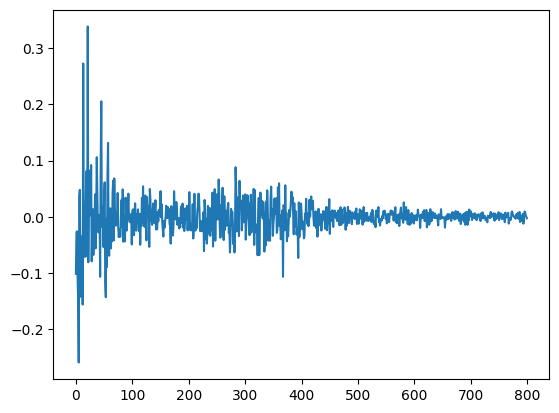

In [68]:
plt.plot(term_tfidf_pca_matrix[2000,:])
plt.show()

In [69]:
# Counter( term_tfidf_pca_matrix[:,0] < 0.25 )
pd.crosstab(dolly_data['category'], term_tfidf_pca_matrix[:,0] > 0.02)

col_0,False,True
category,,
brainstorming,1671,95
classification,2106,30
closed_qa,1404,369
creative_writing,647,62
general_qa,1665,526
information_extraction,1268,238
open_qa,2450,1292
summarization,888,300


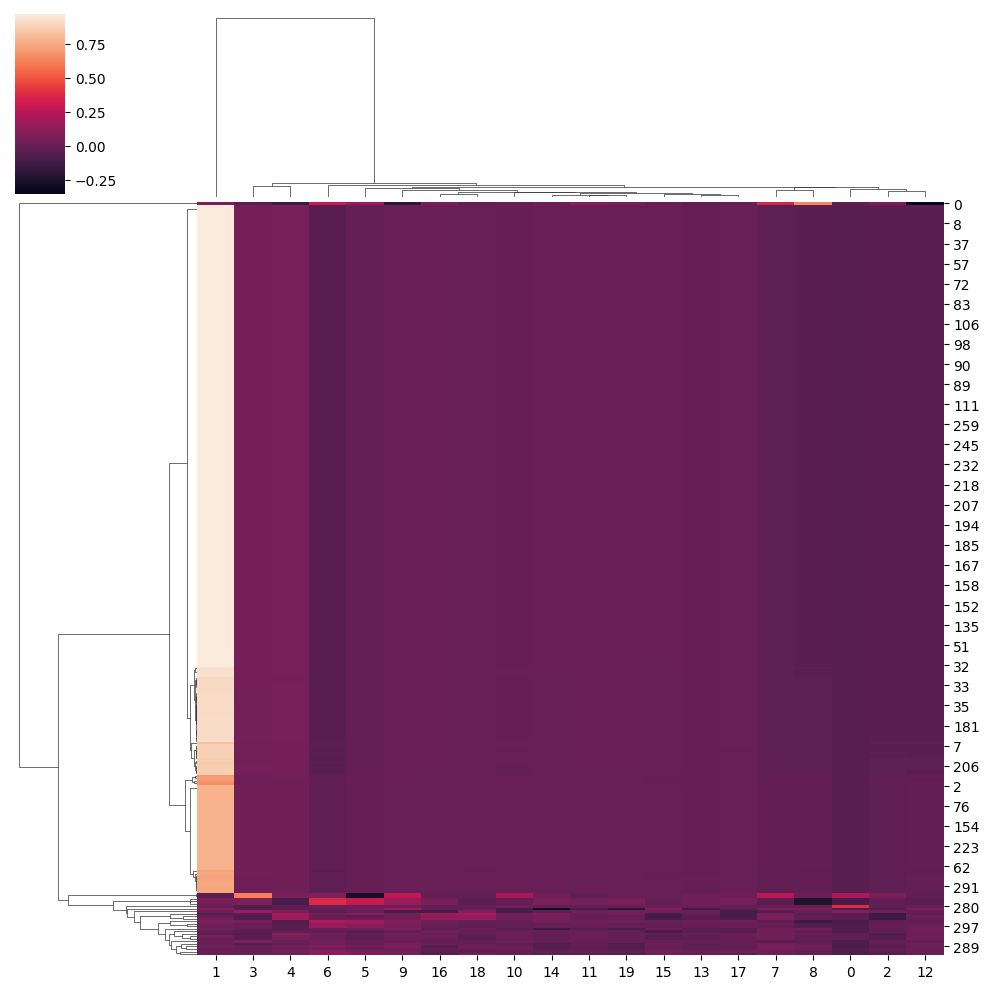

In [70]:
sns.clustermap(term_tfidf_pca_matrix[0:300,0:20])

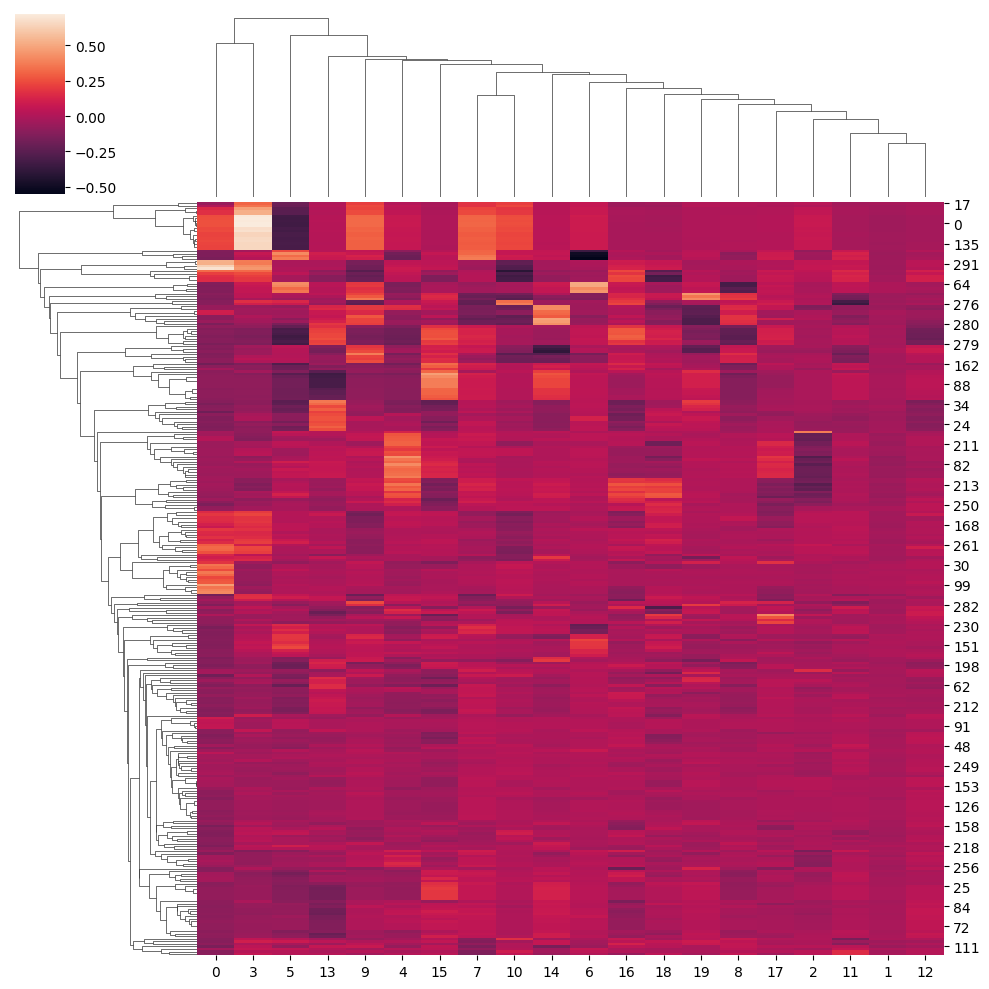

In [71]:
term_tfidf_normalized = term_tfidf_pca_matrix / np.linalg.norm(term_tfidf_pca_matrix, axis=1, ord=2).reshape(-1,1)
term_tfidf_normalized.shape

sns.clustermap(term_tfidf_normalized[term_tfidf_normalized[:,1] < 0.001][0:300,0:20])
# sns.clustermap(X[0:300,0:20])

In [72]:
dolly_data['term_tfidf_normalized'] = list(term_tfidf_normalized)

dd2 = utils.add_cluster_cols(dolly_data, embedding_col='term_tfidf_normalized', prefix='term_tfidf_cl', letters='ABCD', max_threshold=10)

dd2

,instruction,context,response,category,has_context,instruction_vector,response_vector,instruction_A,instruction_B,response_A,...,inst_tfidfpc_D,inst_tfidfpc_E,inst_tfidfpc_F,inst_tfidfpc_G,inst_tfidfpc_H,term_tfidf_normalized,term_tfidf_cl_A,term_tfidf_cl_B,term_tfidf_cl_C,term_tfidf_cl_D
99,What is investment banking?,,Investment banking pertains to certain activit...,open_qa,False,"[0.08775357902050018, -0.03719477728009224, -0...","[0.08770543336868286, -0.1230563148856163, -0....",inst_A01,inst_B02,resp_A13,...,inst_tfidfpc_D001,inst_tfidfpc_E001,inst_tfidfpc_F001,inst_tfidfpc_G001,inst_tfidfpc_H001,"[0.41907401423005564, -0.0008419032274710278, ...",term_tfidf_cl_A01,term_tfidf_cl_B01,term_tfidf_cl_C001,term_tfidf_cl_D0001
2260,What is wholesale banking?,,Wholesale banking is the provision of services...,open_qa,False,"[0.022732555866241455, -0.05329542234539986, -...","[0.07926635444164276, -0.12626200914382935, -0...",inst_A01,inst_B02,resp_A13,...,inst_tfidfpc_D001,inst_tfidfpc_E001,inst_tfidfpc_F001,inst_tfidfpc_G001,inst_tfidfpc_H001,"[0.5046646334678835, 0.002026672841175168, -0....",term_tfidf_cl_A01,term_tfidf_cl_B01,term_tfidf_cl_C001,term_tfidf_cl_D0001
8179,What is fractional-reserve banking?,,Fractional-reserve banking is the system of ba...,open_qa,False,"[0.007597330491989851, -0.007931902073323727, ...","[0.046446118503808975, -0.03791014105081558, -...",inst_A01,inst_B02,resp_A13,...,inst_tfidfpc_D001,inst_tfidfpc_E001,inst_tfidfpc_F001,inst_tfidfpc_G001,inst_tfidfpc_H001,"[0.3970604638553441, -0.000943319414929169, -0...",term_tfidf_cl_A01,term_tfidf_cl_B01,term_tfidf_cl_C001,term_tfidf_cl_D0001
11561,What is retail banking?,,"Retail banking, also known as consumer banking...",open_qa,False,"[0.035445619374513626, 0.032762762159109116, -...","[0.11637887358665466, -0.051019322127103806, -...",inst_A01,inst_B02,resp_A13,...,inst_tfidfpc_D001,inst_tfidfpc_E001,inst_tfidfpc_F001,inst_tfidfpc_G001,inst_tfidfpc_H001,"[0.5046646334678835, 0.002026672841175168, -0....",term_tfidf_cl_A01,term_tfidf_cl_B01,term_tfidf_cl_C001,term_tfidf_cl_D0001
14622,What is core banking?,,Core banking is a banking service provided by ...,open_qa,False,"[0.021664900705218315, -0.04343309998512268, -...","[0.0447213239967823, -0.07586733251810074, -0....",inst_A01,inst_B02,resp_A13,...,inst_tfidfpc_D001,inst_tfidfpc_E001,inst_tfidfpc_F001,inst_tfidfpc_G001,inst_tfidfpc_H001,"[0.41980982292090174, -0.0009137842544700454, ...",term_tfidf_cl_A01,term_tfidf_cl_B01,term_tfidf_cl_C001,term_tfidf_cl_D0001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10079,How spicy is the hottest peppers,,The hottest pepper is the ghost pepper with a ...,open_qa,False,"[-0.03758760914206505, -0.08408567309379578, -...","[-0.007898143492639065, -0.08732812851667404, ...",inst_A07,inst_B44,resp_A03,...,inst_tfidfpc_D001,inst_tfidfpc_E001,inst_tfidfpc_F001,inst_tfidfpc_G001,inst_tfidfpc_H001,"[0.11757883370420114, -0.031194571146045284, 0...",term_tfidf_cl_A16,term_tfidf_cl_B85,term_tfidf_cl_C488,term_tfidf_cl_D1090
3358,What colour usually is the wax surrounding Eda...,,The colour usually is yellow or orange.,open_qa,False,"[-0.017854616045951843, -0.06899305433034897, ...","[0.018224680796265602, 0.02399013191461563, -0...",inst_A06,inst_B30,resp_A04,...,inst_tfidfpc_D001,inst_tfidfpc_E001,inst_tfidfpc_F001,inst_tfidfpc_G001,inst_tfidfpc_H001,"[0.2335973798846723, -0.04517014931182045, 0.0...",term_tfidf_cl_A16,term_tfidf_cl_B85,term_tfidf_cl_C488,term_tfidf_cl_D1090
12903,Wha is the Dynamite!! 2010,Dynamite!! 2010 was a mixed martial arts and k...,The Dynamite!! 2010 was a mixed martial arts a...,summarization,True,"[-0.05694551393389702, -0.0025428507942706347,...","[-0.028673116117715836, 0.014884993433952332, ...",inst_A11,inst_B59,resp_A13,...,inst_tfidfpc_D001,inst_tfidfpc_E001,inst_tfidfpc_F001,inst_tfidfpc_G001,inst_tfidfpc_H001,"[0.2931752988846104, -0.014605757368439259, 0....",term_tfidf_cl_A16,term_tfi

In [73]:
Counter(dd2['term_tfidf_cl_A'])


Counter({'term_tfidf_cl_A14': 6866,
         'term_tfidf_cl_A16': 1917,
         'term_tfidf_cl_A11': 1557,
         'term_tfidf_cl_A06': 657,
         'term_tfidf_cl_A13': 599,
         'term_tfidf_cl_A10': 568,
         'term_tfidf_cl_A01': 563,
         'term_tfidf_cl_A05': 402,
         'term_tfidf_cl_A12': 339,
         'term_tfidf_cl_A04': 277,
         'term_tfidf_cl_A03': 268,
         'term_tfidf_cl_A07': 240,
         'term_tfidf_cl_A09': 222,
         'term_tfidf_cl_A02': 188,
         'term_tfidf_cl_A08': 175,
         'term_tfidf_cl_A15': 173})

# Topic Modeling

Using [BERTopic](https://maartengr.github.io/BERTopic/index.html#quick-start)

In [74]:
from bertopic import BERTopic

import pickle
import os.path

INSTRUCTION_TOPIC_MODEL_FILE = "BERTopic_instruction_model.pkl"

if os.path.exists(INSTRUCTION_TOPIC_MODEL_FILE):
    topic_model = pickle.load( open(INSTRUCTION_TOPIC_MODEL_FILE, 'rb'))
else:
    topic_model = BERTopic()
    topic_model.fit(dolly_data['instruction'])
    pickle.dump(topic_model, open(INSTRUCTION_TOPIC_MODEL_FILE, 'wb'))

topics, probs = topic_model.transform(dolly_data['instruction'])

In [75]:
?topic_model._extract_topics

Signature:
topic_model._extract_topics(
    documents: pandas.core.frame.DataFrame,
    embeddings: numpy.ndarray = None,
    mappings=None,
)
Docstring:
Extract topics from the clusters using a class-based TF-IDF

Arguments:
    documents: Dataframe with documents and their corresponding IDs

Returns:
    c_tf_idf: The resulting matrix giving a value (importance score) for each word per topic
File:      c:\users\rmhorton\miniconda3\lib\site-packages\bertopic\_bertopic.py
Type:      method

In [76]:
pd.DataFrame({'topic':topics,'prob':probs})

Counter([round(p, 1) for p in probs])

threshold = 0.5
pd.crosstab(dolly_data['category'], topics)

col_0,-1,0,1,2,3,4,5,6,7,8,...,281,282,283,284,285,286,287,288,289,290
category,,,,,,,,,,,,,,,,,,,,,
brainstorming,718,28,35,18,19,11,10,9,3,13,...,3,0,1,0,1,0,4,0,0,0
classification,811,43,29,26,26,16,19,14,14,15,...,0,1,0,1,1,0,0,2,0,0
closed_qa,683,52,18,25,16,17,9,8,10,11,...,0,0,0,1,3,0,1,0,0,1
creative_writing,279,23,16,4,16,7,4,9,2,1,...,0,2,1,1,0,0,0,0,0,0
general_qa,869,44,29,22,28,21,25,20,23,12,...,1,0,1,1,0,0,3,2,2,2
information_extraction,605,35,27,14,26,12,15,10,11,20,...,0,2,0,1,0,0,1,0,0,3
open_qa,1506,75,66,44,57,32,18,28,17,27,...,1,0,1,3,3,4,2,2,2,1
summarization,481,30,19,8,20,6,5,10,6,5,...,0,1,1,3,0,2,0,1,1,0


In [77]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,4981,-1_what_the_to_for,"[what, the, to, for, in, from, secs, of, how, ...","[Given this reference text, what sport other t..."
1,0,406,0_he_born_who_was,"[he, born, who, was, did, where, reference, di...",[When was Bobby Moore born and when did he die...
2,1,238,1_percussion_string_instrument_identify,"[percussion, string, instrument, identify, or,...",[Identify which instrument is string or percus...
3,2,222,2_rock_album_band_bands,"[rock, album, band, bands, songs, music, song,...",[Van Halen (/væn ˈheɪlɛn/ van HAY-len) was an ...
4,3,220,3_books_harry_potter_book,"[books, harry, potter, book, titles, novels, b...","[Give me a title of one of the ""Harry Potter"" ..."
...,...,...,...,...,...
287,286,10,286_transistor_electronics_semiconductors_ics,"[transistor, electronics, semiconductors, ics,...",[Extract 3 areas based on the following passag...
288,287,10,287_poker_hand_pot_holdem,"[poker, hand, pot, holdem, bet, ak, friend, ra...","[What is the best hand in poker?, What is the ..."
289,288,10,288_hockey_stanley_nhl_team,"[hockey, stanley, nhl, team, detroit, professi...","[Who won the 2018 NHL Stanley Cup Finals?, Whi..."
290,289,10,289_tornadoes_tornado_avalanches_likelihood,"[tornadoes, tornado, avalanches, likelihood, e...",[What are the most common causes of avalanches...


In [78]:
topic_model.get_document_info(dolly_data['instruction'])

,Document,Topic,Name,Representation,Representative_Docs,Top_n_words,Probability,Representative_document
0,Which is a species of fish? Banjo or Guitar,80,80_languages_language_spoken_tamil,"[languages, language, spoken, tamil, arabic, s...",[How many official languages are spoken in Ind...,languages - language - spoken - tamil - arabic...,1.000000,False
1,Identify which instrument is string or percuss...,227,227_greek_mythology_goddesses_goddess,"[greek, mythology, goddesses, goddess, gods, s...","[What were the Gorgons of Greek mythology?, Ac...",greek - mythology - goddesses - goddess - gods...,1.000000,False
2,Identify which instrument is string or woodwin...,-1,-1_what_the_to_for,"[what, the, to, for, in, from, secs, of, how, ...","[Given this reference text, what sport other t...",what - the - to - for - in - from - secs - of ...,0.000000,False
3,Identify which instrument is string or percuss...,1,1_percussion_string_instrument_identify,"[percussion, string, instrument, identify, or,...",[Identify which instrument is string or percus...,percussion - string - instrument - identify - ...,0.813267,False
4,Identify which instrument is string or percuss...,44,44_woodwind_instrument_string_identify,"[woodwind, instrument, string, identify, or, w...",[Identify which instrument is string or woodwi...,woodwind - instrument - string - identify - or...,1.000000,False
...,...,...,...,...,...,...,...,...
15006,What are some interesting facts about Nelson M...,-1,-1_what_the_to_for,"[what, the, to, for, in, from, secs, of, how, ...","[Given this reference text, what sport other t...",what - the - to - for - in - from - secs - of ...,0.000000,False
15007,What is the best way to get from London to Paris.,13,13_extinct_alive_animal_species,"[extinct, alive, animal, species, identify, to...",[Identify which animal species is alive or ext...,extinct - alive - animal - species - identify ...,0.148329,False
15008,Given a reference text that describes the air ...,58,58_located_where_village_town,"[located, where, village, town, birkenhead, fa...",[Given this paragraph about the Pearl Mill Vil...,located - where - village - town - birkenhead ...,1.000000,False
15009,What is a good slogan for carpet?,19,19_marvel_dc_universe_belong,"[marvel, dc, universe, belong, characters, com...",[Which characters belong to DC or Marvel Unive...,marvel - dc - universe - belong - characters -...,0.046432,False


In [79]:
# -1 is outliers, 0 is most common topic
topic_model.get_topic(1)

[('percussion', 0.13096196311156524),
 ('string', 0.11661705177567859),
 ('instrument', 0.11521532563081881),
 ('identify', 0.07900330987091445),
 ('or', 0.030452137033263608),
 ('which', 0.028683575486785632),
 ('drum', 0.021394928830872587),
 ('is', 0.011975300133836473),
 ('drums', 0.010044079305119007),
 ('stick', 0.009051696160536598)]

In [80]:
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer

pipe = make_pipeline(
    TfidfVectorizer(ngram_range=(4,9), min_df=5, stop_words=None),
    TruncatedSVD(100)
)

ngram_topic_model = BERTopic(embedding_model=pipe)
ngram_topic_model.fit(dolly_data['instruction'])

In [81]:
ngram_topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,4523,-1_why_how_does_what,"[why, how, does, what, is, who, can, do, you, to]",[Summarize the opening of the Gettysburg Addre...
1,0,228,0_percussion_string_instrument_identify,"[percussion, string, instrument, identify, or,...",[Identify which instrument is string or percus...
2,1,154,1_difference_between_and_guitar,"[difference, between, and, guitar, bees, trans...",[What is the difference between football and s...
3,2,137,2_paragraph_this_given_about,"[paragraph, this, given, about, magnesium, he,...","[Given this paragraph about magnesium, what is..."
4,3,101,3_reference_text_given_about,"[reference, text, given, about, he, tell, she,...",[Given a reference text about Reginaldo de Fra...
...,...,...,...,...,...
442,441,10,441_generally_indic_grafana_relocate,"[generally, indic, grafana, relocate, eiffel, ...","[What is the size of the Eiffel Tower?, Which ..."
443,442,10,442_yonkers_millenium_schenectady_badge,"[yonkers, millenium, schenectady, badge, hobok...","[What is Agent Fox Mulder's badge number?, How..."
444,443,10,443_ottomans_umpire_tissues_bachelors,"[ottomans, umpire, tissues, bachelors, homeown...",[What is the field of study that looks at tiss...
445,444,10,444_grandchild_artistic_digeon_fervent,"[grandchild, artistic, digeon, fervent, freak,...","[Extract why Tim Lincecum was called ""The Frea..."


In [82]:
ngram_topic_model.get_topic(2)

[('paragraph', 0.0359839906127329),
 ('this', 0.02688248034870949),
 ('given', 0.02565942130832983),
 ('about', 0.02082101680041523),
 ('magnesium', 0.015417756805337218),
 ('he', 0.007524310799844352),
 ('limits', 0.006669609108310037),
 ('arlington', 0.006669609108310037),
 ('typical', 0.006491308085462528),
 ('his', 0.006483102392560596)]

In [83]:
ngram_topic_model.get_document_info(dolly_data['instruction'])

,Document,Topic,Name,Representation,Representative_Docs,Top_n_words,Probability,Representative_document
0,Which is a species of fish? Banjo or Guitar,5,5_fish_species_or_which,"[fish, species, or, which, sea, mola, bream, n...",[Which is a species of fish? Rock bass or Rock...,fish - species - or - which - sea - mola - bre...,1.000000,False
1,Identify which instrument is string or percuss...,0,0_percussion_string_instrument_identify,"[percussion, string, instrument, identify, or,...",[Identify which instrument is string or percus...,percussion - string - instrument - identify - ...,0.737378,False
2,Identify which instrument is string or woodwin...,25,25_woodwind_string_instrument_identify,"[woodwind, string, instrument, identify, bass,...",[Identify which instrument is string or woodwi...,woodwind - string - instrument - identify - ba...,0.264840,False
3,Identify which instrument is string or percuss...,0,0_percussion_string_instrument_identify,"[percussion, string, instrument, identify, or,...",[Identify which instrument is string or percus...,percussion - string - instrument - identify - ...,0.974502,False
4,Identify which instrument is string or percuss...,0,0_percussion_string_instrument_identify,"[percussion, string, instrument, identify, or,...",[Identify which instrument is string or percus...,percussion - string - instrument - identify - ...,0.566371,False
...,...,...,...,...,...,...,...,...
15006,What are some interesting facts about Nelson M...,67,67_paragraphs_storage_battery_hydrogen,"[paragraphs, storage, battery, hydrogen, multi...",[Given these paragraphs about battery storage ...,paragraphs - storage - battery - hydrogen - mu...,0.009274,False
15007,What is the best way to get from London to Paris.,18,18_way_best_according_get,"[way, best, according, get, to, steak, relax, ...","[What is the best way to travel to space?, Wha...",way - best - according - get - to - steak - re...,0.401440,False
15008,Given a reference text that describes the air ...,-1,-1_why_how_does_what,"[why, how, does, what, is, who, can, do, you, to]",[Summarize the opening of the Gettysburg Addre...,why - how - does - what - is - who - can - do ...,0.000000,False
15009,What is a good slogan for carpet?,142,142_maareech_proud_ciao_coding,"[maareech, proud, ciao, coding, carpet, kaashi...",[Should technology and software coding subject...,maareech - proud - ciao - coding - carpet - ka...,1.000000,False


## Framework topic model

In [84]:
from sentence_transformers import SentenceTransformer
from sklearn.base import BaseEstimator, TransformerMixin

class WeightedSentenceTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, weight_vector=1, st_model=SENTENCE_TRANSFORMER_MODEL_NAME):
        self.model = SentenceTransformer(st_model)
        self.weight_vector = weight_vector
        # self.columns = columns
    
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        embeddings = self.model.encode(X)
        return [ self.weight_vector * e for e in embeddings]


In [85]:
framework_models = [ 'instruction_' + x for x in ['given_text', 'alternatives', 'output_format', 
                                                  'identify', 'how_does', 'why_is', 'what is', 'extract']]

framework_coef = M_coef[ framework_models ].mean(axis=1)

framework_wst = WeightedSentenceTransformer(weight_vector=framework_coef, st_model=SENTENCE_TRANSFORMER_MODEL_NAME)

framework_topic_model = BERTopic(embedding_model=framework_wst)
framework_topic_model.fit(dolly_data['instruction'])


In [101]:
framework_topic_info = framework_topic_model.get_topic_info()

HTML(framework_topic_info.to_html())

,Topic,Count,Name,Representation,Representative_Docs
0,-1,4958,-1_what_to_secs_the,"[what, to, secs, the, in, for, is, how, are, do]","[Given this paragraph about Atlantic Hall in Nigeria, how many students does it hold, where is located and when did it open?, Why do people like working from home?, Tomas is a 50-yr-old nonsmoking male who was recently invited by colleagues to participate in a 10-km trail run. He's been walking for 40 minutes 3 days a week, something he's maintained “for years”. His goal is to run the entire 10K race without stopping. He reports having what he describes as a “mild heart attack” at 45 years old, completed cardiac rehabilitation, and has had no problems since. He takes a statin and a low-dose aspirin daily. During his last visit (2 years ago) with his cardiologist, no changes were noted in his medical condition. Can you brainstorm reasons why Tomas's physician would prescribe a statin? Make sure to explain how this medication works.]"
1,0,367,0_he_born_who_was,"[he, born, who, was, did, where, john, die, died, reference]","[Given a reference text about a president, tell me when he died., Given a reference text about James Henry Richards, tell me what sport he played, where he was born and where he died., Based on this paragraph from Wikipedia, where was Jerry Garcia born, how many fingers did he have, and where did he attend college?]"
2,1,243,1_album_rock_band_bands,"[album, rock, band, bands, songs, music, song, beatles, grateful, albums]","[What are the best selling albums of all time? Give me the list with the name of the artist and the name of the album, What are the top 5 rock bands of all time?, What are some of the greatest rock bands of all time?]"
3,2,233,2_books_harry_potter_book,"[books, harry, potter, book, fiction, novels, titles, by, read, written]","[Give me a title of one of the ""Harry Potter"" novels., How many books are there in the Harry Potter series?, Give me a title of one of the ""Harry Potter"" novels.]"
4,3,232,3_percussion_string_instrument_identify,"[percussion, string, instrument, identify, or, which, drum, is, stick, pipa]","[Identify which instrument is string or percussion: Talking drum, Tambura, Identify which instrument is string or percussion: Bass drum, Goje, Identify which instrument is string or percussion: Talempong, Guitar]"
5,4,175,4_comma_results_separated_display,"[comma, results, separated, display, separate, format, extract, them, passage, from]","[From the passage list down the various models of Tesla vehicle. List the results in comma separated format., List all the places and countries mentioned in the paragraph in the format [Place] separated by comma., From the passage identify the founders of Confinity. Display the results in comma separated format.]"
6,5,174,5_movies_film_films_movie,"[movies, film, films, movie, grossing, horror, tom, star, action, actors]","[Give me a list of some best Action movies, What are some of the best movies for kids?, How to make movies?]"
7,6,146,6_wood_tools_house_items,"[wood, tools, house, items, home, bedroom, desk, kitchen, apartment, stapler]","[What are five totally distinct, creative ways to describe the usefulness of a broken stapler., You've bought a condominium in the city, your first home, with more rooms than your previous apartments. It doesn't have a garage or any yard. Which of the following items would be handy? A lawnmower, a bus pass, a security system, more bathroom towels, wall art, gardening tools, a washer and dryer set, a car, Would you typically find each of the following items in a bathroom, bedroom, kitchen or living room? Couch, pillow, dish soap, bedside table, oven, shower, toilet, coffee table, coffee machine]"
8,7,143,7_tv_show_shows_television,"[tv, show, shows, television, seinfeld, series, characters, cast, lasso, ted]","[What is the current best TV show?, Name some characters from the TV show ""Friends""?, Tell me whether these are TV shows or movies]"
9,8,133,8_dog_dogs_breed_bre

In [125]:
framework_topic_hierarchy = framework_topic_model.hierarchical_topics(dolly_data['instruction'])

framework_topic_hierarchy['num_descendants'] = [ len(t) for t in framework_topic_hierarchy['Topics'] ]

framework_topic_hierarchy.sort_values('num_descendants', ascending=False)

100%|███████████████████████████████████████████████████████████████████████████████| 288/288 [00:01<00:00, 247.87it/s]


,Parent_ID,Parent_Name,Topics,Child_Left_ID,Child_Left_Name,Child_Right_ID,Child_Right_Name,Distance,num_descendants
287,576,which_or_the_of_is,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",569,football_league_basketball_sports_baseball,575,or_which_identify_of_the,1.717013,289
286,575,or_which_identify_of_the,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",574,or_which_identify_is_of,404,comma_extract_them_separate_format,1.658273,267
285,574,or_which_identify_is_of,"[0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",567,countries_cities_south_ski_san,573,or_which_identify_is_instrument,1.622660,262
284,573,or_which_identify_is_instrument,"[0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",572,or_which_is_instrument_identify,297,manufacturer_car_american_german_identify,1.572216,242
283,572,or_which_is_instrument_identify,"[0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",571,instrument_which_identify_string_or,566,you_dog_my_your_write,1.510128,239
...,...,...,...,...,...,...,...,...,...
91,380,africa_ethiopia_ago_tanzania_economy,"[185, 232]",232,ago_tanzania_archaeology_paleontology_homo,185,africa_economy_ethiopia_capita_gabon,0.899377,2
93,382,love_negative_positive_am_sentiment,"[183, 203]",183,negative_positive_sentiment_anger_am,203,love_lovers_affection_express_relationship,0.907028,2
94,383,weight_lose_pound_heavy_weigh,"[182, 216]",182,weight_lose_loss_loose_fat,216,pound_heavy_feathers_weigh_feather,0.907144,2
95,384,magnesium_hydrogen_solid_oxygen_gas,"[33, 243]",243,hydrogen_paragraphs_storage_natural_forms,33,magnesium_solid_oxygen_gas_liquid,0.907827,2


In [143]:
edge_list = [] # list of rows to go in edge table
node_name = {} # dictionary mapping id to name
node_descendants = {} # map id to num_descendants

def add_node(new_node_id, new_node_name, num_descendants=0):
    # alert if names change
    if new_node_id in node_name:
        if node_name[ new_node_id ] != new_node_name:
            print(f'node {new_node_id} changed names!')
    node_name[ new_node_id ] = new_node_name
    node_descendants[ new_node_id ] = num_descendants


for row in framework_topic_hierarchy.to_dict(orient='records'):
    edge_list.append( {'from':row['Parent_ID'], 'to': row['Child_Left_ID'], 'weight': row['Distance']})
    edge_list.append( {'from':row['Parent_ID'], 'to': row['Child_Right_ID'], 'weight': row['Distance']})
    add_node(row['Parent_ID'],  row['Parent_Name'], row['num_descendants'])
    add_node(row['Child_Left_ID'],  row['Child_Left_Name'])
    add_node(row['Child_Right_ID'],  row['Child_Right_Name'])
    # node_name[ row['Parent_ID'] ] = row['Parent_Name']
    # node_name[ row['Child_Left_ID'] ] = row['Child_Left_Name']
    # node_name[ row['Child_Right_ID'] ] = row['Child_Right_Name']


framework_topic_hierarchy_nodes = pd.DataFrame([ {'id': k, 
                                                  'label': f'{k}\n{v}\n{node_descendants[k]}',
                                                  'title': f'{k}\n{v}\n{node_descendants[k]}',
                                                  'num_descendants': node_descendants[k]} 
                                                for k, v in node_name.items()])

framework_topic_hierarchy_edges = pd.DataFrame(edge_list)


In [146]:
node_count_threshold = 5

filtered_framework_topic_hierarchy_nodes = framework_topic_hierarchy_nodes[framework_topic_hierarchy_nodes['num_descendants'] > node_count_threshold]

keep_edges = [ ((node_descendants[ row['from'] ] > node_count_threshold) & (node_descendants[ row['to'] ] > node_count_threshold))
                                   for row in framework_topic_hierarchy_edges.to_dict(orient='records')]

filtered_framework_topic_hierarchy_edges = framework_topic_hierarchy_edges[keep_edges]

print("number of nodes:", len(filtered_framework_topic_hierarchy_nodes))
print("number of edges:", len(filtered_framework_topic_hierarchy_edges))


tgraph.export_to_vis_js(filtered_framework_topic_hierarchy_nodes, filtered_framework_topic_hierarchy_edges, 'Framework Topic Hierarchy', 'framework_topic_hierarchy_viz_filtered.html')

number of nodes: 86
number of edges: 85
export_to_vis_js: self is a <class 'ThoughtGrapher.ThoughtGrapher'>, nodes_df is a <class 'pandas.core.frame.DataFrame'>, edges_df is a <class 'pandas.core.frame.DataFrame'>, title is a <class 'str'>, and html_file_name is a <class 'str'>
get_vis_js_html: self is a <class 'ThoughtGrapher.ThoughtGrapher'>, nodes_df is a <class 'pandas.core.frame.DataFrame'>, and edges_df is a <class 'pandas.core.frame.DataFrame'>


In [87]:
framework_topic_model.get_document_info(dolly_data['instruction'])

,Document,Topic,Name,Representation,Representative_Docs,Top_n_words,Probability,Representative_document
0,Which is a species of fish? Banjo or Guitar,11,11_fish_species_fishing_or,"[fish, species, fishing, or, which, trout, sea...",[Which is a species of fish? Paradise fish or ...,fish - species - fishing - or - which - trout ...,0.424604,False
1,Identify which instrument is string or percuss...,3,3_percussion_string_instrument_identify,"[percussion, string, instrument, identify, or,...",[Identify which instrument is string or percus...,percussion - string - instrument - identify - ...,0.622907,False
2,Identify which instrument is string or woodwin...,36,36_woodwind_instrument_string_identify,"[woodwind, instrument, string, identify, or, w...",[Identify which instrument is string or woodwi...,woodwind - instrument - string - identify - or...,1.000000,False
3,Identify which instrument is string or percuss...,3,3_percussion_string_instrument_identify,"[percussion, string, instrument, identify, or,...",[Identify which instrument is string or percus...,percussion - string - instrument - identify - ...,0.783978,False
4,Identify which instrument is string or percuss...,3,3_percussion_string_instrument_identify,"[percussion, string, instrument, identify, or,...",[Identify which instrument is string or percus...,percussion - string - instrument - identify - ...,0.455225,False
...,...,...,...,...,...,...,...,...
15006,What are some interesting facts about Nelson M...,-1,-1_what_to_secs_the,"[what, to, secs, the, in, for, is, how, are, do]",[Given this paragraph about Atlantic Hall in N...,what - to - secs - the - in - for - is - how -...,0.000000,False
15007,What is the best way to get from London to Paris.,117,117_york_city_new_boroughs,"[york, city, new, boroughs, london, things, ap...","[What are the five boroughs of New York City?,...",york - city - new - boroughs - london - things...,0.710693,False
15008,Given a reference text that describes the air ...,-1,-1_what_to_secs_the,"[what, to, secs, the, in, for, is, how, are, do]",[Given this paragraph about Atlantic Hall in N...,what - to - secs - the - in - for - is - how -...,0.000000,False
15009,What is a good slogan for carpet?,-1,-1_what_to_secs_the,"[what, to, secs, the, in, for, is, how, are, do]",[Given this paragraph about Atlantic Hall in N...,what - to - secs - the - in - for - is - how -...,0.000000,False


In [88]:
framework_coef

0     -2.939645
1      0.161020
2     -0.547492
3     -0.821335
4     -0.483784
         ...   
379   -1.072855
380   -0.027305
381    0.174398
382   -1.622256
383   -0.891974
Length: 384, dtype: float64

In [89]:
1/framework_coef

0      -0.340177
1       6.210427
2      -1.826510
3      -1.217530
4      -2.067040
         ...    
379    -0.932092
380   -36.623035
381     5.734011
382    -0.616425
383    -1.121110
Length: 384, dtype: float64

## Inverse framework model

In [90]:
inverse_framework_wst = WeightedSentenceTransformer(weight_vector=1/framework_coef, st_model=SENTENCE_TRANSFORMER_MODEL_NAME)
inverse_framework_topic_model = BERTopic(embedding_model=inverse_framework_wst)
inverse_framework_topic_model.fit(dolly_data['instruction'])

In [104]:
inverse_framework_topic_info = inverse_framework_topic_model.get_topic_info()

HTML(inverse_framework_topic_info.to_html())

,Topic,Count,Name,Representation,Representative_Docs
0,-1,5335,-1_what_the_extract_in,"[what, the, extract, in, from, for, to, passage, of, is]","[Extract the names of all of the albums that Taylor Swift has released. Separate them with a comma., List the components from this text into a comma separated list, Think up five popular cities to visit on vacation in the United States]"
1,0,402,0_he_born_who_was,"[he, born, who, was, did, where, john, reference, died, die]","[Given the reference text about Fidel Castro, tell me where he was born, where he studied, and when he was the leader of Cuba., Given a reference text about Pablo Picasso, tell me when and where he was born, why he was famous, and what his most famous accomplishment was as a professional, Given a reference text about a president, tell me when he died.]"
2,1,238,1_percussion_string_instrument_identify,"[percussion, string, instrument, identify, or, which, drum, is, drums, stick]","[Identify which instrument is string or percussion: Talking drum, Tambura, Identify which instrument is string or percussion: Bass drum, Goje, Identify which instrument is string or percussion: Bell, Tro]"
3,2,232,2_dog_dogs_cat_cats,"[dog, dogs, cat, cats, breed, breeds, pet, landlord, pets, retriever]","[Are cats or dogs better?, How are cats different than dogs?, what is a dog?]"
4,3,178,3_movies_movie_film_films,"[movies, movie, film, films, grossing, star, horror, tom, action, actors]","[Give me a list of some best Action movies, What are some of the best movies for kids?, How to make movies?]"
5,4,152,4_tv_show_shows_television,"[tv, show, shows, television, bravolebrities, seinfeld, housewives, series, cast, lasso]","[What is the current best TV show?, Name some characters from the TV show ""Friends""?, Tell me whether these are TV shows or movies]"
6,5,121,5_university_school_universities_schools,"[university, school, universities, schools, public, college, uva, mascot, private, ivy]","[Name three schools that are part of the university of London, Classify each of the following universities as public or private: Duke, Wake Forest, University of Florida, Florida Atlantic University, University of Alabama, Harvard, Yale, Tell me whether the following are public or private universities in the United States: Harvard University, University of Florida, University of Massachusetts Amherst, Cornell University, Amherst College, Colby College, and the University of Michigan Ann Arbor.]"
7,6,119,6_fruit_fruits_vegetables_banana,"[fruit, fruits, vegetables, banana, apples, apple, vegetable, tomato, orange, potato]","[Is an apple a fruit or a vegetable, Classify each of the following as either a fruit or a vegetables: tomato, apple, orange, potato, banana., Tell me which of these things are fruits or vegetables: Carrot, Apple, Orange, Potato, Peas, Broccoli, Pears]"
8,7,110,7_books_fiction_book_novels,"[books, fiction, book, novels, written, fantasy, novel, read, authors, wrote]","[What are some of the best books written by Indian Authors?, Give me a list of the best high fantasy books or series that I should read, What are some of the most famous fantasy books ever written?]"
9,8,108,8_she_her_lady_gaga,"[she, her, lady, gaga, anne, barbie, kardashian, octavia, butler, who]","[Given a reference text about Anne Elizabeth Howells, tell me the names' of her parents and how she died., Given a reference text about Isabel Emily Jay, tell me where she studied and how old she was when she retired., Given this paragraph on Lady Gaga, tell me where she was born, the middle and high school she attended and how she considered herself in high school.]"


In [92]:
inverse_framework_topic_model.get_document_info(dolly_data['instruction'])

,Document,Topic,Name,Representation,Representative_Docs,Top_n_words,Probability,Representative_document
0,Which is a species of fish? Banjo or Guitar,12,12_fish_species_or_which,"[fish, species, or, which, sea, mola, steelhea...","[Which is a species of fish? Trout or Bear, Wh...",fish - species - or - which - sea - mola - ste...,0.702341,False
1,Identify which instrument is string or percuss...,1,1_percussion_string_instrument_identify,"[percussion, string, instrument, identify, or,...",[Identify which instrument is string or percus...,percussion - string - instrument - identify - ...,0.888653,False
2,Identify which instrument is string or woodwin...,36,36_woodwind_instrument_string_identify,"[woodwind, instrument, string, identify, or, w...",[Identify which instrument is string or woodwi...,woodwind - instrument - string - identify - or...,1.000000,False
3,Identify which instrument is string or percuss...,1,1_percussion_string_instrument_identify,"[percussion, string, instrument, identify, or,...",[Identify which instrument is string or percus...,percussion - string - instrument - identify - ...,0.975156,False
4,Identify which instrument is string or percuss...,1,1_percussion_string_instrument_identify,"[percussion, string, instrument, identify, or,...",[Identify which instrument is string or percus...,percussion - string - instrument - identify - ...,0.533490,False
...,...,...,...,...,...,...,...,...
15006,What are some interesting facts about Nelson M...,-1,-1_what_the_extract_in,"[what, the, extract, in, from, for, to, passag...",[Extract the names of all of the albums that T...,what - the - extract - in - from - for - to - ...,0.000000,False
15007,What is the best way to get from London to Paris.,-1,-1_what_the_extract_in,"[what, the, extract, in, from, for, to, passag...",[Extract the names of all of the albums that T...,what - the - extract - in - from - for - to - ...,0.000000,False
15008,Given a reference text that describes the air ...,-1,-1_what_the_extract_in,"[what, the, extract, in, from, for, to, passag...",[Extract the names of all of the albums that T...,what - the - extract - in - from - for - to - ...,0.000000,False
15009,What is a good slogan for carpet?,-1,-1_what_the_extract_in,"[what, the, extract, in, from, for, to, passag...",[Extract the names of all of the albums that T...,what - the - extract - in - from - for - to - ...,0.000000,False


# To Do
      
* Combine fragments
    - Get original sentence, and run it through the tokenizer to put it in the same format as the fragments (it looks like some small words are missing?)
    - Find the location of each fragment in the original.
    - merge any fragments whose positions overlap.